In [2]:
import pandas as pd
import torch
from torch import cuda
import seqeval
from seqeval.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification, AdamW, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import evaluate
import numpy as np
from datasets import load_dataset
import ast
from transformers import Trainer
from transformers import TrainingArguments
from docx import Document
from docx.shared import RGBColor

In [34]:
# 60 train, 20 dev, 20 test
train_df = pd.read_csv('data/processed/phee/ace/train_w_test_tag_new_mapped.csv')
dev_df = pd.read_csv('data/processed/phee/ace/dev_w_test_tag_new_mapped.csv')
test_df = pd.read_csv('data/processed/phee/ace/test_w_test_tag_new_mapped.csv')


# train_df = train_df[['Sentence', 'Med_Tag']]
# train_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)
# dev_df = dev_df[['Sentence', 'Med_Tag']]
# dev_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)
# test_df = test_df[['Sentence', 'Med_Tag']]
# test_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)

train_df['sentence'] = train_df['sentence'].apply(lambda x: x.split())
train_df['tag'] = train_df['tag'].apply(lambda x: x.split())
dev_df['sentence'] = dev_df['sentence'].apply(lambda x: x.split())
dev_df['tag'] = dev_df['tag'].apply(lambda x: x.split())
test_df['sentence'] = test_df['sentence'].apply(lambda x: x.split())
test_df['tag'] = test_df['tag'].apply(lambda x: x.split())

train_dev_df = pd.concat([train_df, dev_df], ignore_index=True)

# save to csv
train_dev_df.to_csv('data/processed/phee/ace/final_train.csv', index=False) # final_train is train+dev
test_df.to_csv('data/processed/phee/ace/final_dev.csv', index=False) # final_dev is test
test_df.to_csv('data/processed/phee/ace/final_test.csv', index=False) # final_test is test
# train_dev_df


In [3]:
# mtsamples
eval_df = pd.read_csv('data/processed/mtsamples/doc-patient-multiclass.csv')
# rename columns of eval_df
eval_df.rename(columns={"description": "sentence", "label": "tag"}, inplace=True)
eval_df['sentence'] = eval_df['sentence'].apply(lambda x: x.split())
eval_df.to_csv('data/processed/mtsamples/final_eval.csv', index=False) # final_test is test
eval_df
# drop duplicates
eval_df.drop_duplicates(subset=['sentence'], inplace=True, ignore_index=True)
eval_df

,sentence,tag
0,"[Patient, :, H, ello, Doctor, !, My, name, is,...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
1,"[Doctor, :, Do, you, have, constipation, ?]","['O', 'O', 'O', 'O', 'O', 'I-Problem', 'O']"
2,"[Patient, :, Yes, ,, I, had, a, blood, test, d...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-Test', ..."
3,"[Patient, :, I, am, on, ferrous, sulfate, to, ...","['O', 'O', 'O', 'O', 'O', 'I-Treatment', 'I-Tr..."
4,"[Doctor, :, Usually, ,, people, who, take, fer...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-Treatme..."
...,...,...
83,"[Patient, :, No, itching, cream, ?]","['O', 'O', 'O', 'I-Treatment', 'I-Treatment', ..."
84,"[Doctor, :, A, local, reaction, can, occu, r, .]","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
85,"[Doctor, :, Not, until, you, get, it, checked]","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
86,"[Patient, :, Ok, thank, you]","['O', 'O', 'O', 'O', 'O']"


In [8]:
label2id = {'O': 0,
 'I-Treatment': 1,
 'I-Test': 2,
 'I-Problem': 3,
 'I-Background': 4,
 'I-Other': 5}

In [9]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
# load 'data/processed/phee/ace/final_dev.csv'
test_dataset = pd.read_csv('data/processed/phee/ace/final_dev.csv')
sum(test_dataset['tag'].map(lambda x: ast.literal_eval(x)).map(lambda x: len(x)))

21795

In [7]:

dataset = load_dataset('csv', data_files={'train': 'data/processed/phee/ace/final_train.csv', 'validation': 'data/processed/phee/ace/final_dev.csv', 'test': 'data/processed/phee/ace/final_test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [35]:
unique_tags = pd.unique([tag for sublist in train_df['tag'] for tag in sublist])
# Create label2id dictionary
print(unique_tags)
label2id = {tag: id for id, tag in enumerate(unique_tags)}

# Create id2label dictionary by swapping keys with values
id2label = {id: tag for tag, id in label2id.items()}

# Print the dictionaries
print("label2id:", label2id)
print("id2label:", id2label)

['O' 'I-Treatment' 'I-Test' 'I-Problem' 'I-Background' 'I-Other']
label2id: {'O': 0, 'I-Treatment': 1, 'I-Test': 2, 'I-Problem': 3, 'I-Background': 4, 'I-Other': 5}
id2label: {0: 'O', 1: 'I-Treatment', 2: 'I-Test', 3: 'I-Problem', 4: 'I-Background', 5: 'I-Other'}


In [9]:
train_df['sentence']

0       [objective, :, to, test, the, hypothesis, that...
1       [an, evaluation, of, ovarian, structure, and, ...
2       [phenobarbital, hepatotoxicity, in, an, 8, -, ...
3       [the, authors, report, a, case, of, balint, sy...
4       [according, to, the, naranjo, probability, sca...
                              ...                        
2788    [l, -, t4, stimulated, lymphocyte, transformat...
2789    [a, 53, -, year, -, old, man, developed, lower...
2790    [a, mentally, retarded, 23, -, year, -, old, w...
2791    [after, 5, days, of, treatment, with, il, -, 2...
2792    [acute, pancreatitis, after, long, -, term, 5,...
Name: sentence, Length: 2793, dtype: object

In [12]:
def transform(example_batch):
    example_batch['sentence'] = ast.literal_eval(example_batch['sentence'])
    example_batch['tag'] = ast.literal_eval(example_batch['tag'])
    example_batch['tag'] = [label2id[label] for label in example_batch['tag']]
    return example_batch

for type in ['train', 'validation', 'test']:
    dataset[type] = dataset[type].map(transform)

NameError: name 'dataset' is not defined

In [13]:
tokenizer = AutoTokenizer.from_pretrained("samrawal/bert-base-uncased_clinical-ner")

In [16]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            new_labels.append(label)

    return new_labels

In [23]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation=True, is_split_into_words=True
    )
    # # Calculate the lengths of each tokenized sequence
    # lengths = [len(seq) for seq in tokenized_inputs["input_ids"]]

    # # Find the maximum length
    # max_length = max(lengths)

    # print("Maximum sequence length:", max_length)
    
    all_labels = examples["tag"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [25]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [17]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset['train'].column_names,
)

NameError: name 'dataset' is not defined

In [16]:
tokenized_datasets.column_names

{'train': ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'token_type_ids', 'attention_mask', 'labels']}

In [17]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(2)])
batch["labels"]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    1,    0,    0,    2,    2,    2,    2,    2,    0,    0,
            3,    3,    3,    0,    0,    0,    0,    0,    0, -100],
        [-100,    0,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    4,    0,    4,    4,    0,    0,    0,    1,    1,    1,
            0,    3,    3,    3,    0,    0,    0,    0,    0,    3,    3,    3,
            3,    3,    3,    0,    0,    0, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

In [18]:
predictions = [['O', 'I-LOC', 'I-LOC', 'I-LOC', 'I-h']]
references = [['O', 'I-LOC', 'I-LOC', 'I-LOC', 'I-h']]

In [19]:
import seqeval.metrics 
print(seqeval.metrics.classification_report(references, predictions)  )

              precision    recall  f1-score   support

         LOC       1.00      1.00      1.00         1
           h       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [18]:
def untokenize_labels_predictions(word_ids, true_labels, predictions):
    untokenized_true_labels = []
    untokenized_predictions = []

    for sublist_word_ids, sublist_true_labels, sublist_predictions in zip(word_ids, true_labels, predictions):
        current_labels = []
        current_predictions = []
        last_word_id = None

        for word_id, label, prediction in zip(sublist_word_ids[1:-1], sublist_true_labels, sublist_predictions):
            # Skip if this word_id is the same as the last one (it's a subword)
            if word_id == last_word_id:
                continue

            current_labels.append(label)
            current_predictions.append(prediction)
            last_word_id = word_id

        untokenized_true_labels.append(current_labels)
        untokenized_predictions.append(current_predictions)

    return untokenized_true_labels, untokenized_predictions


In [21]:
# word ids of the tokenized test set to find the original words
val_sentences = dataset['validation']['sentence']
val_word_ids = []
for sentence in val_sentences:
    val_word_ids.append(tokenizer(sentence, truncation=True, is_split_into_words=True).word_ids())

dataset['validation']['sentence'][0]


['after',
 'therapy',
 'with',
 'parenteral',
 'amiodarone',
 '(',
 '2300',
 'mg',
 'in',
 '3',
 'days',
 ')',
 'and',
 'other',
 'measures',
 ',',
 'signs',
 'of',
 'congestive',
 'heart',
 'failure',
 'disappeared',
 ';',
 'subsequently',
 'the',
 'patient',
 'developed',
 'jaundice',
 ',',
 'marked',
 'increase',
 'in',
 'serum',
 'transaminase',
 'levels',
 'and',
 'fall',
 'in',
 'prothrombin',
 'time',
 ',',
 'and',
 'histologic',
 'changes',
 'of',
 'severe',
 'centrilobular',
 'necrosis',
 'were',
 'observed',
 'in',
 'hepatic',
 'biopsy',
 '.']

In [22]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    untokenized_true_labels, untokenized_predictions = untokenize_labels_predictions(val_word_ids, true_labels, true_predictions)
    
                
    
    # span_report = seqeval.metrics.classification_report(untokenized_true_labels, untokenized_predictions)
    # print("SPAN REPORT")
    # print(span_report)
    
    flat_true = [label for seq in true_labels for label in seq]
    flat_pred = [label for seq in true_predictions for label in seq]
    report = classification_report(y_pred=flat_pred, y_true=flat_true, output_dict=True)
    report['macro_wo_O'] = {'precision': (report['I-Background']['precision'] + report['I-Other']['precision'] + report['I-Problem']['precision'] + report['I-Test']['precision'] + report['I-Treatment']['precision']) / 5,
    'recall': (report['I-Background']['recall'] + report['I-Other']['recall'] + report['I-Problem']['recall'] + report['I-Test']['recall'] + report['I-Treatment']['recall']) / 5,
    'f1-score': (report['I-Background']['f1-score'] + report['I-Other']['f1-score'] + report['I-Problem']['f1-score'] + report['I-Test']['f1-score'] + report['I-Treatment']['f1-score']) / 5,
    'support': (report['I-Background']['support'] + report['I-Other']['support'] + report['I-Problem']['support'] + report['I-Test']['support'] + report['I-Treatment']['support'])}
    
    report_df = pd.DataFrame(report).round(3).T


    unflat_true = [label for seq in untokenized_true_labels for label in seq]
    unflat_pred = [label for seq in untokenized_predictions for label in seq]
    unreport = classification_report(y_pred=unflat_pred, y_true=unflat_true, output_dict=True)
    unreport['macro_wo_O'] = {'precision': (unreport['I-Background']['precision'] + unreport['I-Other']['precision'] + unreport['I-Problem']['precision'] + unreport['I-Test']['precision'] + unreport['I-Treatment']['precision']) / 5,
    'recall': (unreport['I-Background']['recall'] + unreport['I-Other']['recall'] + unreport['I-Problem']['recall'] + unreport['I-Test']['recall'] + unreport['I-Treatment']['recall']) / 5,
    'f1-score': (unreport['I-Background']['f1-score'] + unreport['I-Other']['f1-score'] + unreport['I-Problem']['f1-score'] + unreport['I-Test']['f1-score'] + unreport['I-Treatment']['f1-score']) / 5,
    'support': (unreport['I-Background']['support'] + unreport['I-Other']['support'] + unreport['I-Problem']['support'] + unreport['I-Test']['support'] + unreport['I-Treatment']['support'])}
    
    un_report_df = pd.DataFrame(unreport).round(3).T

    # accuracy_score_val = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    cm = confusion_matrix(y_pred=flat_pred, y_true=flat_true)
    disp = ConfusionMatrixDisplay(cm, display_labels=np.array(['I-Background','I-Other', 'I-Problem', 'I-Test', 'I-Treatment', 'O']))
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax)

    # Save the figure to an image file
    plt.savefig('analysis/graphs/confusion_matrix.png')
    plt.show()
    print("TOKENIZED REPORT")
    print(report_df)
    print("UNTOKENIZED REPORT")
    print(un_report_df)
    # save all_metrics to file
    with open("analysis/reports/all_metrics.txt", "w") as f:
        # save report to file
        f.write(str(report_df))

    return {
        "precision": report['macro avg']['precision'],
        "recall": report['macro avg']['recall'],
        "f1": report['macro avg']['f1-score'],
        "accuracy": report['accuracy'],
    }

In [23]:
model = AutoModelForTokenClassification.from_pretrained(
    'samrawal/bert-base-uncased_clinical-ner',
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at samrawal/bert-base-uncased_clinical-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.294900,1.126543,0.332081,0.237133,0.224305,0.568257
2,1.003400,0.936076,0.542868,0.376580,0.410803,0.702469
3,0.823900,0.787892,0.561990,0.462815,0.489154,0.794364
4,0.703500,0.702322,0.567019,0.486629,0.508060,0.814067
5,0.623900,0.662100,0.571516,0.479603,0.505950,0.811444
6,0.565400,0.604856,0.571219,0.505552,0.523807,0.829452
7,0.518100,0.576480,0.564440,0.521181,0.533044,0.836329
8,0.478300,0.562138,0.573230,0.504841,0.527867,0.827597
9,0.445000,0.546356,0.564184,0.513380,0.529804,0.832619
10,0.415800,0.521986,0.568484,0.522308,0.536086,0.838856


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/.cond

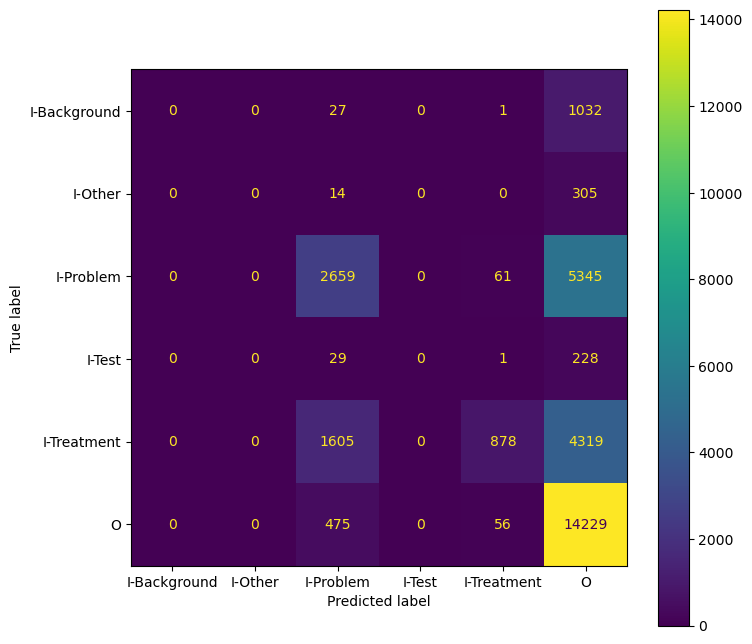

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.000   0.000     0.000   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.553   0.330     0.413   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.881   0.129     0.225   6802.000
O                 0.559   0.964     0.708  14760.000
accuracy          0.568   0.568     0.568      0.568
macro avg         0.332   0.237     0.224  31264.000
weighted avg      0.598   0.568     0.490  31264.000
macro_wo_O        0.287   0.092     0.128  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.000   0.000     0.000    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.543   0.235     0.328   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.861   0.032     0.062   2875.000
O                 0.663   0.984     0.792  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

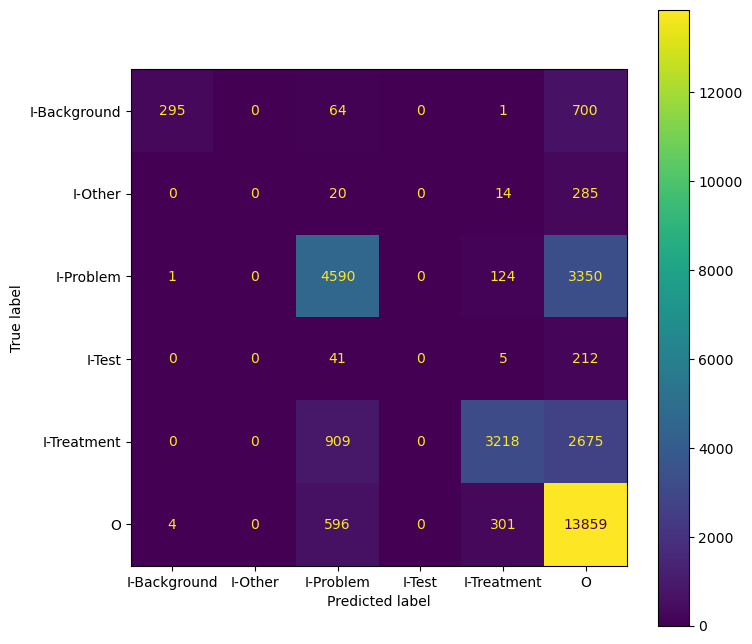

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.983   0.278     0.434   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.738   0.569     0.643   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.879   0.473     0.615   6802.000
O                 0.657   0.939     0.773  14760.000
accuracy          0.702   0.702     0.702      0.702
macro avg         0.543   0.377     0.411  31264.000
weighted avg      0.725   0.702     0.679  31264.000
macro_wo_O        0.520   0.264     0.338  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.983   0.297     0.457    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.720   0.432     0.540   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.842   0.315     0.459   2875.000
O                 0.725   0.971     0.830  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

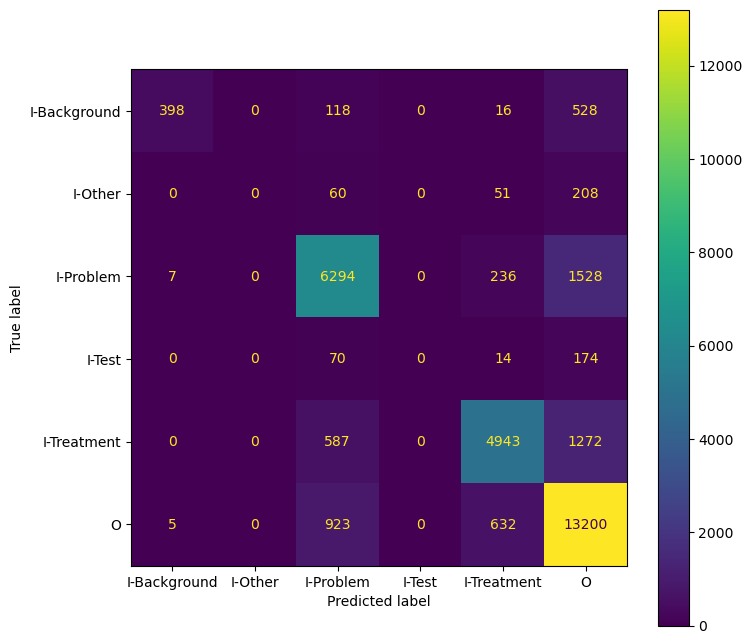

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.971   0.375     0.541   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.782   0.780     0.781   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.839   0.727     0.779   6802.000
O                 0.781   0.894     0.834  14760.000
accuracy          0.794   0.794     0.794      0.794
macro avg         0.562   0.463     0.489  31264.000
weighted avg      0.786   0.794     0.783  31264.000
macro_wo_O        0.518   0.377     0.420  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score  support
I-Background      0.975   0.401     0.568    985.0
I-Other           0.000   0.000     0.000    317.0
I-Problem         0.756   0.674     0.713   3950.0
I-Test            0.000   0.000     0.000    205.0
I-Treatment       0.788   0.580     0.668   2875.0
O                 0.808   0.945     0.871  13463.0
accuracy          0.800 

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

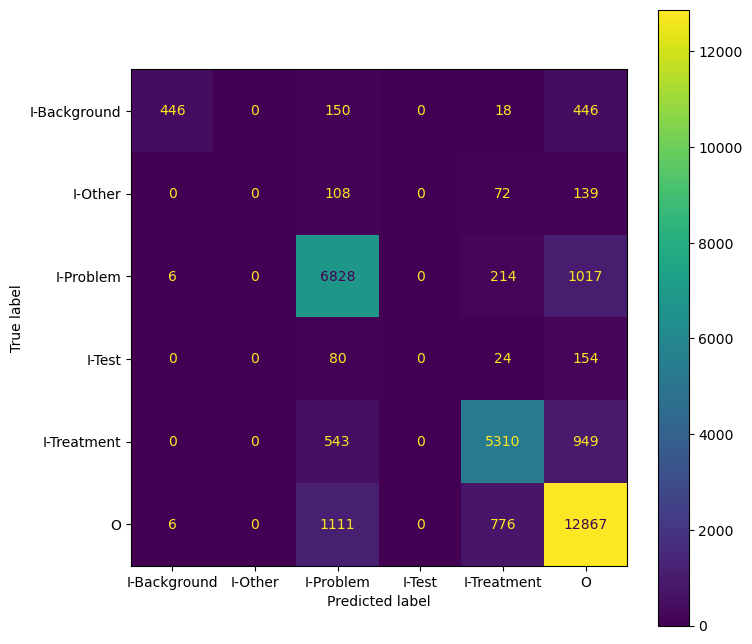

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.974   0.421     0.588   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.774   0.847     0.809   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.828   0.781     0.804   6802.000
O                 0.826   0.872     0.848  14760.000
accuracy          0.814   0.814     0.814      0.814
macro avg         0.567   0.487     0.508  31264.000
weighted avg      0.803   0.814     0.804  31264.000
macro_wo_O        0.515   0.410     0.440  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.978   0.450     0.616    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.736   0.767     0.751   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.765   0.658     0.708   2875.000
O                 0.845   0.925     0.883  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

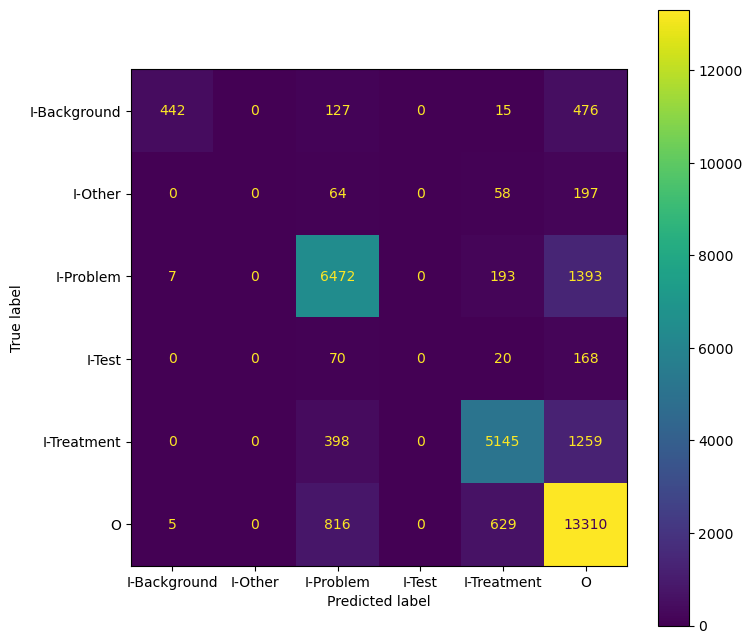

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.974   0.417     0.584   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.814   0.802     0.808   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.849   0.756     0.800   6802.000
O                 0.792   0.902     0.843  14760.000
accuracy          0.811   0.811     0.811      0.811
macro avg         0.572   0.480     0.506  31264.000
weighted avg      0.802   0.811     0.801  31264.000
macro_wo_O        0.527   0.395     0.438  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.978   0.446     0.612    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.786   0.716     0.749   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.798   0.618     0.697   2875.000
O                 0.821   0.947     0.879  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

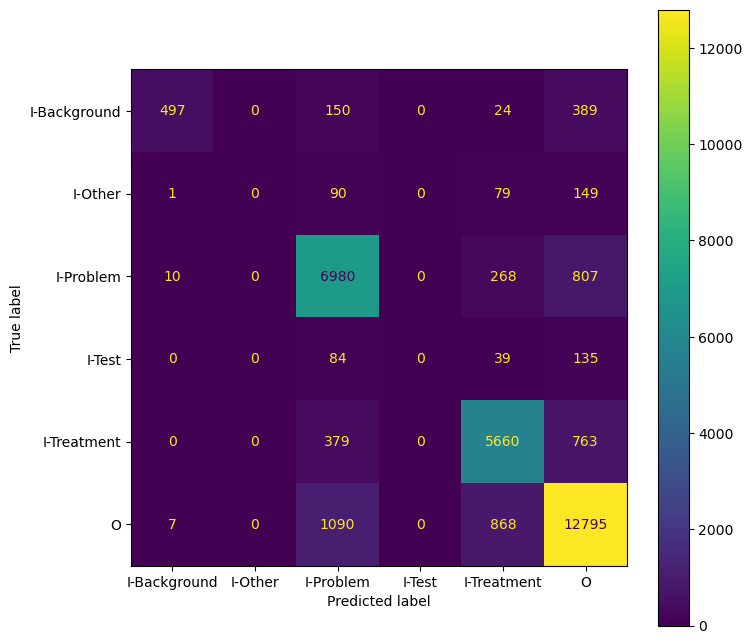

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.965   0.469     0.631   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.796   0.865     0.829   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.816   0.832     0.824   6802.000
O                 0.851   0.867     0.859  14760.000
accuracy          0.829   0.829     0.829      0.829
macro avg         0.571   0.506     0.524  31264.000
weighted avg      0.817   0.829     0.820  31264.000
macro_wo_O        0.515   0.433     0.457  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.969   0.502     0.661    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.758   0.800     0.779   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.752   0.725     0.738   2875.000
O                 0.865   0.921     0.892  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

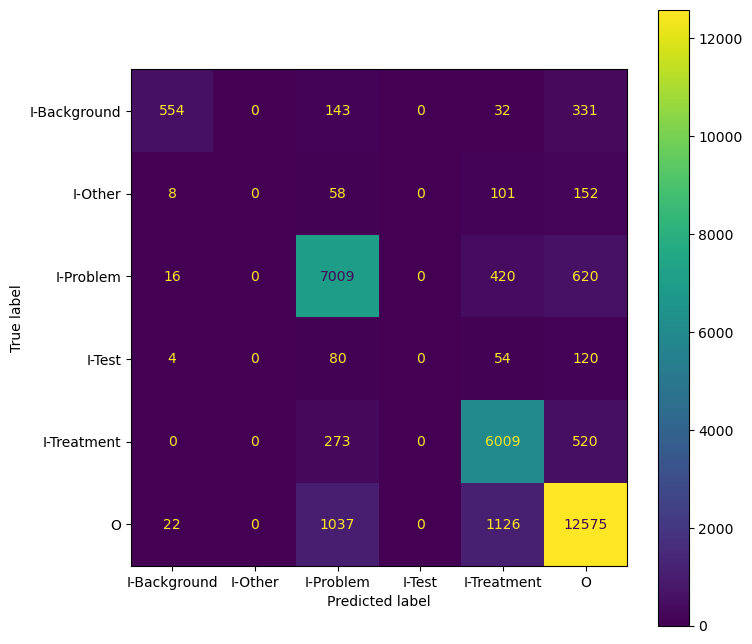

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.917   0.523     0.666   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.815   0.869     0.841   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.776   0.883     0.826   6802.000
O                 0.878   0.852     0.865  14760.000
accuracy          0.836   0.836     0.836      0.836
macro avg         0.564   0.521     0.533  31264.000
weighted avg      0.825   0.836     0.828  31264.000
macro_wo_O        0.502   0.455     0.467  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.924   0.555     0.694    985.00
I-Other           0.000   0.000     0.000    317.00
I-Problem         0.775   0.815     0.794   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.708   0.801     0.752   2875.00
O                 0.888   0.910     0.898  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

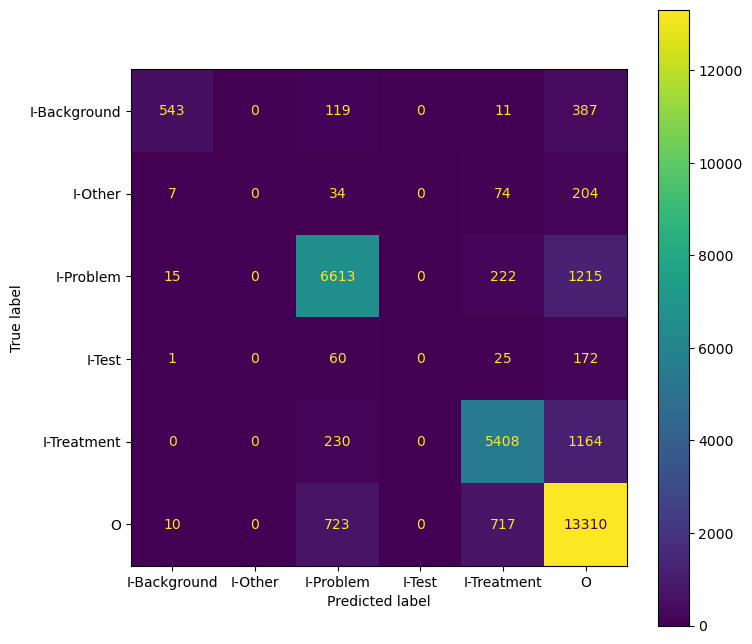

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.943   0.512     0.664   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.850   0.820     0.835   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.838   0.795     0.816   6802.000
O                 0.809   0.902     0.853  14760.000
accuracy          0.828   0.828     0.828      0.828
macro avg         0.573   0.505     0.528  31264.000
weighted avg      0.815   0.828     0.818  31264.000
macro_wo_O        0.526   0.425     0.463  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.948   0.541     0.689    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.822   0.748     0.783   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.777   0.670     0.719   2875.000
O                 0.838   0.944     0.888  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

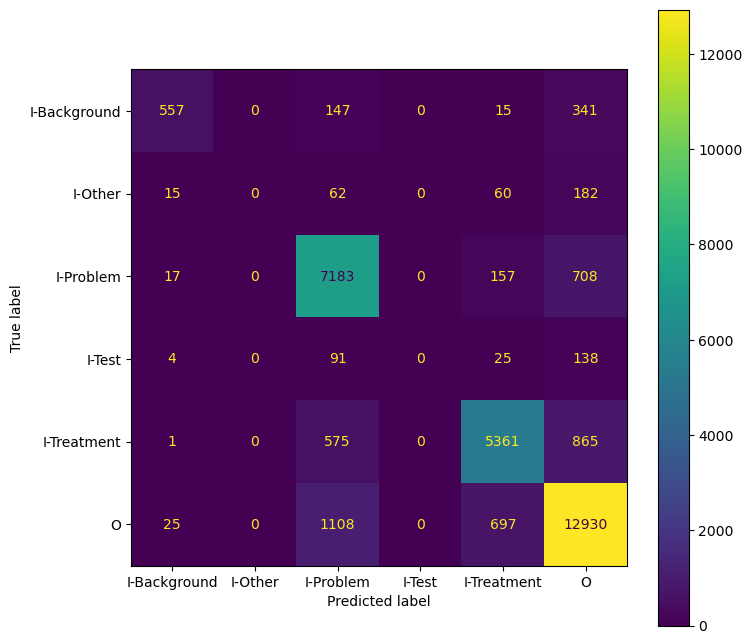

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.900   0.525     0.663   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.784   0.891     0.834   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.849   0.788     0.817   6802.000
O                 0.853   0.876     0.864  14760.000
accuracy          0.833   0.833     0.833      0.833
macro avg         0.564   0.513     0.530  31264.000
weighted avg      0.820   0.833     0.823  31264.000
macro_wo_O        0.506   0.441     0.463  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.912   0.556     0.691    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.752   0.835     0.792   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.800   0.674     0.731   2875.000
O                 0.868   0.928     0.897  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

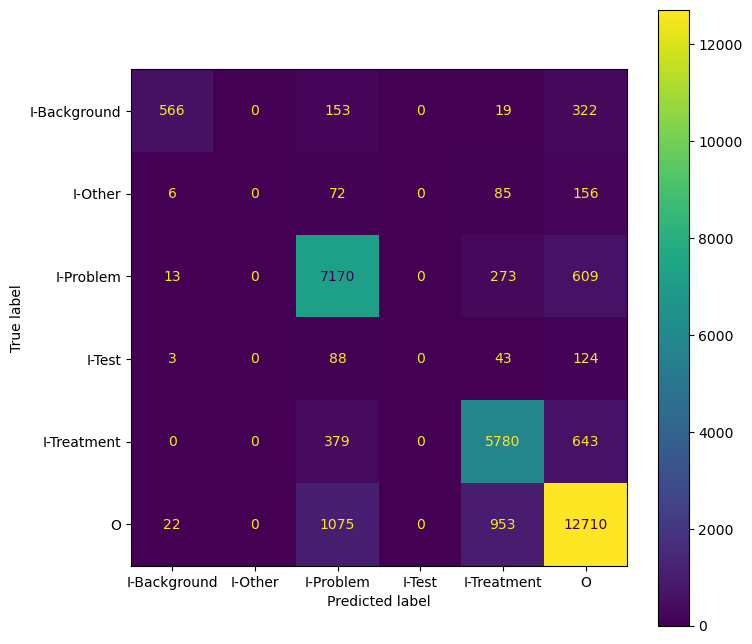

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.928   0.534     0.678   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.802   0.889     0.843   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.808   0.850     0.828   6802.000
O                 0.873   0.861     0.867  14760.000
accuracy          0.839   0.839     0.839      0.839
macro avg         0.568   0.522     0.536  31264.000
weighted avg      0.826   0.839     0.830  31264.000
macro_wo_O        0.508   0.455     0.470  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.933   0.563     0.703    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.766   0.836     0.800   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.745   0.754     0.749   2875.000
O                 0.883   0.917     0.900  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

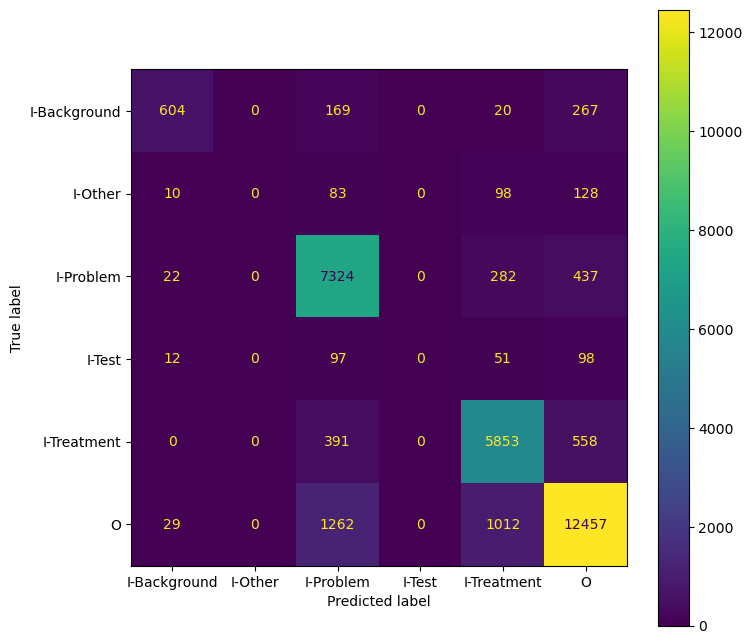

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.892   0.570     0.695   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.785   0.908     0.842   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.800   0.860     0.829   6802.000
O                 0.893   0.844     0.868  14760.000
accuracy          0.839   0.839     0.839      0.839
macro avg         0.562   0.530     0.539  31264.000
weighted avg      0.829   0.839     0.831  31264.000
macro_wo_O        0.496   0.468     0.473  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.900   0.600     0.720    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.738   0.868     0.798   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.733   0.768     0.750   2875.000
O                 0.901   0.902     0.901  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

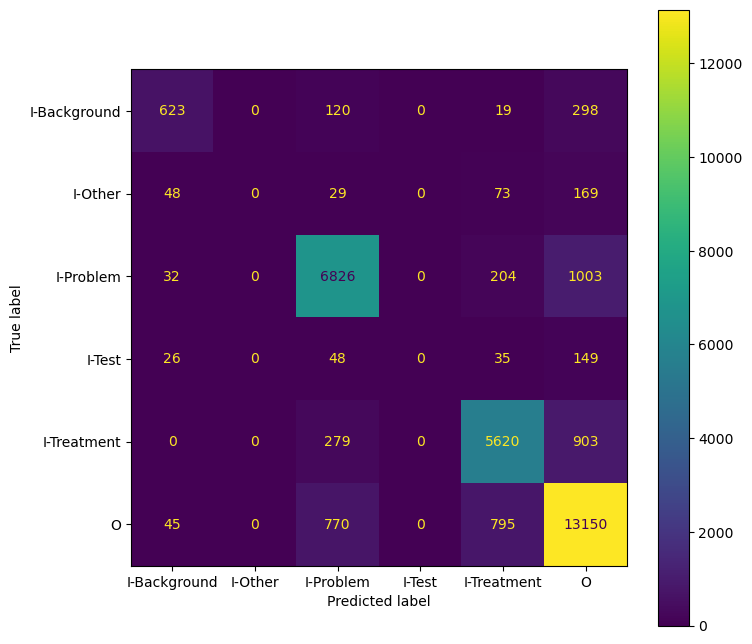

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.805   0.588     0.679   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.846   0.846     0.846   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.833   0.826     0.830   6802.000
O                 0.839   0.891     0.864  14760.000
accuracy          0.839   0.839     0.839      0.839
macro avg         0.554   0.525     0.537  31264.000
weighted avg      0.823   0.839     0.830  31264.000
macro_wo_O        0.497   0.452     0.471  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.826   0.618     0.707    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.818   0.781     0.799   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.775   0.718     0.746   2875.000
O                 0.862   0.936     0.897  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

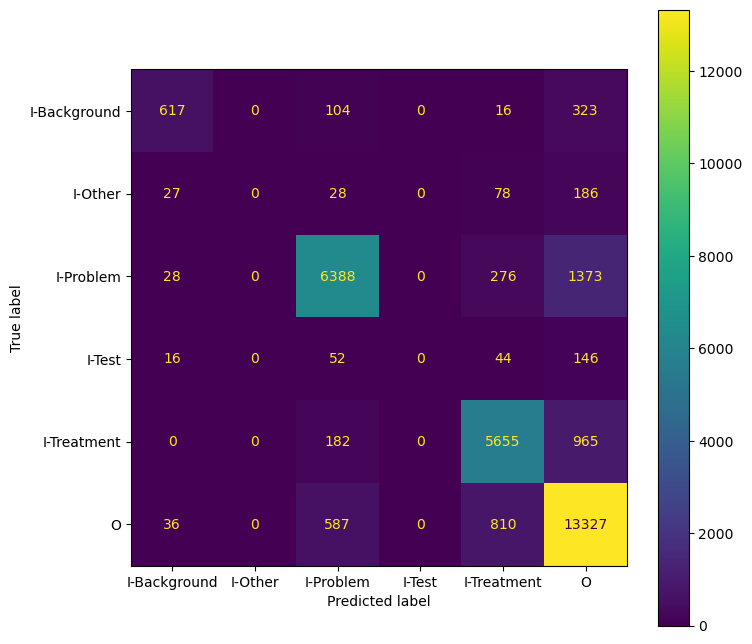

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.852   0.582     0.692   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.870   0.792     0.829   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.822   0.831     0.827   6802.000
O                 0.817   0.903     0.858  14760.000
accuracy          0.831   0.831     0.831      0.831
macro avg         0.560   0.518     0.534  31264.000
weighted avg      0.818   0.831     0.822  31264.000
macro_wo_O        0.509   0.441     0.470  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.873   0.612     0.720    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.842   0.721     0.777   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.765   0.723     0.743   2875.000
O                 0.847   0.944     0.893  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

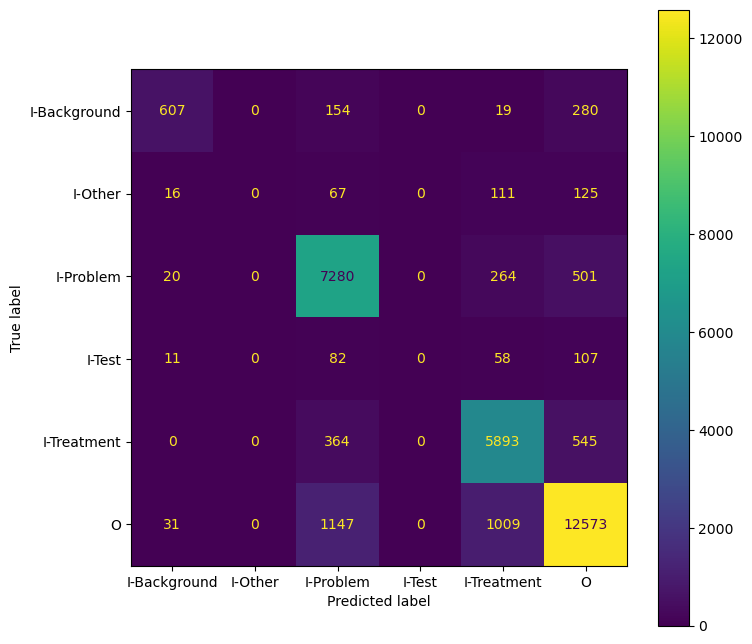

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.886   0.573     0.696   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.801   0.903     0.849   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.801   0.866     0.833   6802.000
O                 0.890   0.852     0.870  14760.000
accuracy          0.843   0.843     0.843      0.843
macro avg         0.563   0.532     0.541  31264.000
weighted avg      0.831   0.843     0.835  31264.000
macro_wo_O        0.498   0.468     0.475  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.894   0.606     0.722    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.760   0.859     0.806   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.736   0.781     0.758   2875.000
O                 0.898   0.908     0.903  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

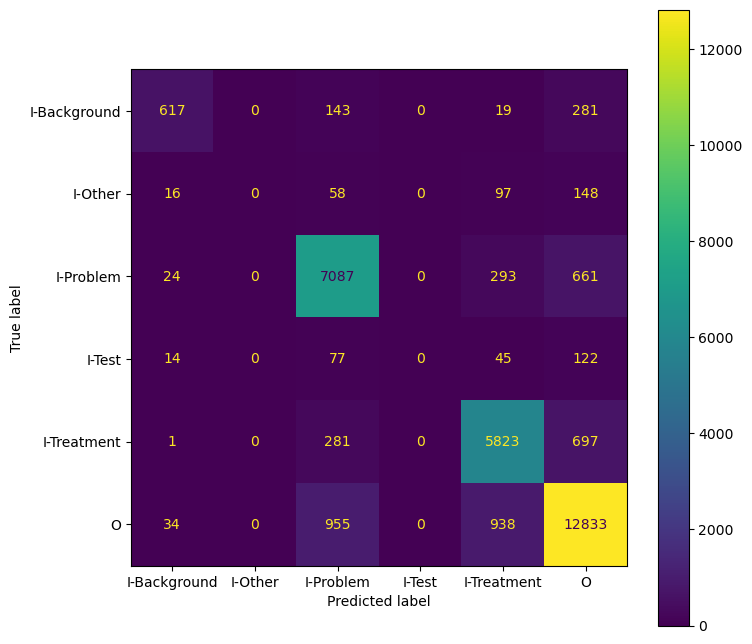

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.874   0.582     0.699   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.824   0.879     0.850   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.807   0.856     0.831   6802.000
O                 0.871   0.869     0.870  14760.000
accuracy          0.843   0.843     0.843      0.843
macro avg         0.563   0.531     0.542  31264.000
weighted avg      0.829   0.843     0.835  31264.000
macro_wo_O        0.501   0.463     0.476  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.886   0.616     0.727    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.786   0.831     0.808   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.741   0.760     0.751   2875.000
O                 0.886   0.920     0.902  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

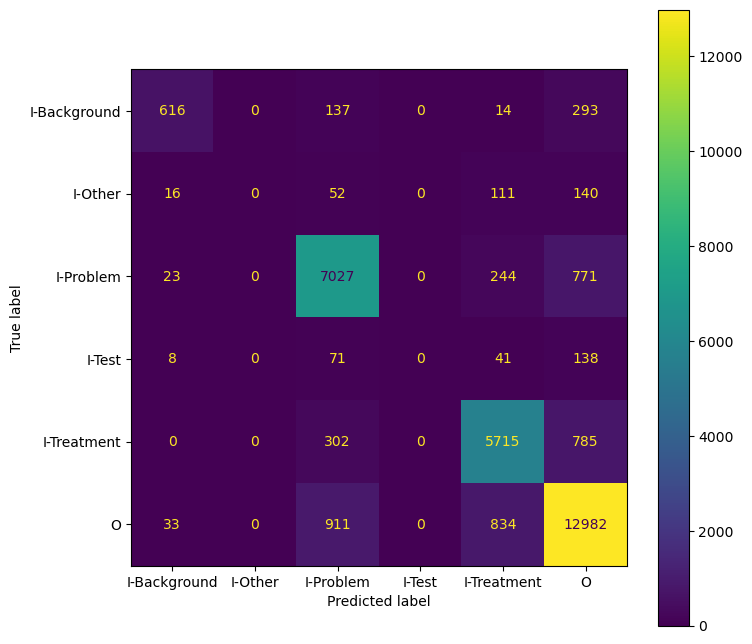

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.885   0.581     0.702   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.827   0.871     0.848   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.821   0.840     0.831   6802.000
O                 0.859   0.880     0.869  14760.000
accuracy          0.843   0.843     0.843      0.843
macro avg         0.565   0.529     0.542  31264.000
weighted avg      0.828   0.843     0.834  31264.000
macro_wo_O        0.507   0.459     0.476  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.898   0.614     0.729    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.793   0.822     0.808   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.757   0.747     0.752   2875.000
O                 0.879   0.927     0.902  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

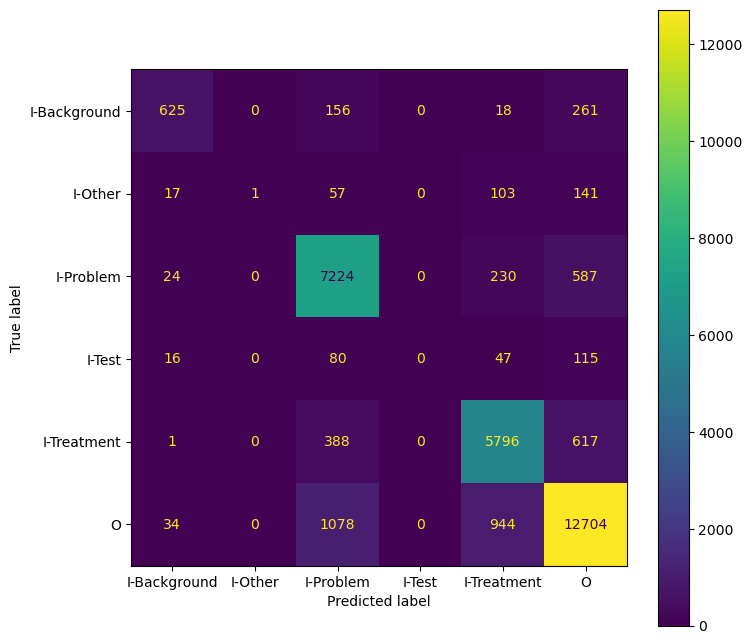

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.872   0.590     0.703   1060.000
I-Other           1.000   0.003     0.006    319.000
I-Problem         0.804   0.896     0.847   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.812   0.852     0.832   6802.000
O                 0.881   0.861     0.871  14760.000
accuracy          0.843   0.843     0.843      0.843
macro avg         0.728   0.534     0.543  31264.000
weighted avg      0.840   0.843     0.834  31264.000
macro_wo_O        0.698   0.468     0.478  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.885   0.624     0.732    985.000
I-Other           1.000   0.003     0.006    317.000
I-Problem         0.766   0.849     0.805   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.748   0.762     0.755   2875.000
O                 0.893   0.915     0.904  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

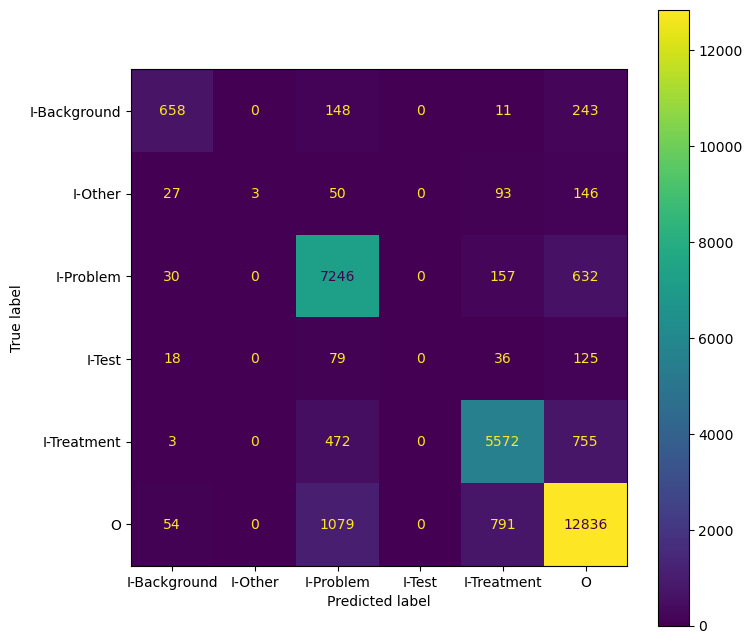

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.833   0.621     0.711   1060.000
I-Other           1.000   0.009     0.019    319.000
I-Problem         0.799   0.898     0.846   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.837   0.819     0.828   6802.000
O                 0.871   0.870     0.870  14760.000
accuracy          0.842   0.842     0.842      0.842
macro avg         0.723   0.536     0.546  31264.000
weighted avg      0.838   0.842     0.833  31264.000
macro_wo_O        0.694   0.470     0.481  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.848   0.654     0.739    985.000
I-Other           1.000   0.009     0.019    317.000
I-Problem         0.764   0.849     0.804   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.774   0.724     0.748   2875.000
O                 0.888   0.920     0.904  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

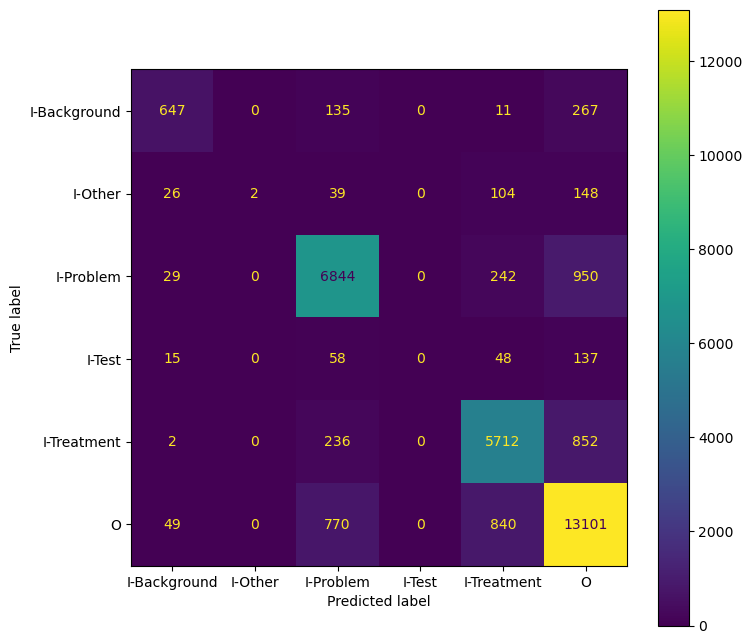

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.842   0.610     0.708   1060.000
I-Other           1.000   0.006     0.012    319.000
I-Problem         0.847   0.849     0.848   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.821   0.840     0.830   6802.000
O                 0.848   0.888     0.867  14760.000
accuracy          0.841   0.841     0.841      0.841
macro avg         0.726   0.532     0.544  31264.000
weighted avg      0.836   0.841     0.833  31264.000
macro_wo_O        0.702   0.461     0.480  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.859   0.644     0.736    985.000
I-Other           1.000   0.006     0.013    317.000
I-Problem         0.816   0.790     0.803   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.759   0.748     0.753   2875.000
O                 0.872   0.932     0.901  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

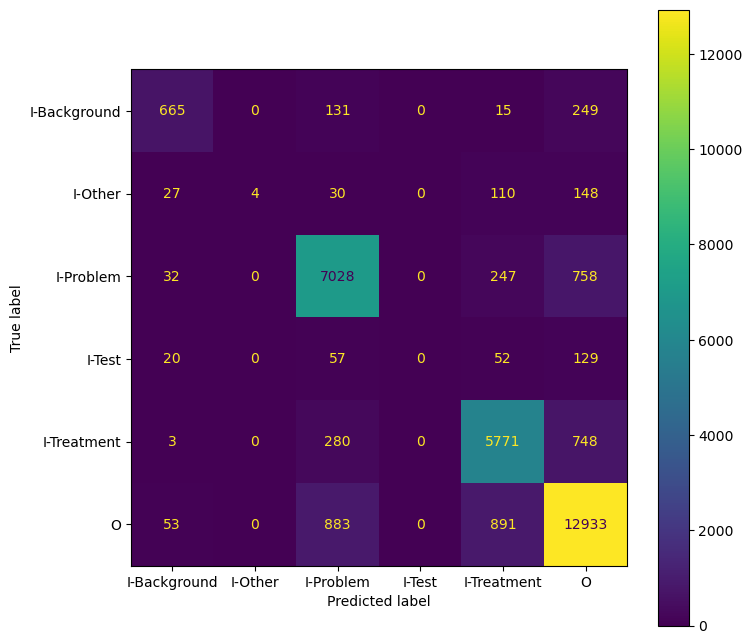

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.831   0.627     0.715   1060.000
I-Other           1.000   0.013     0.025    319.000
I-Problem         0.836   0.871     0.853   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.814   0.848     0.831   6802.000
O                 0.864   0.876     0.870  14760.000
accuracy          0.844   0.844     0.844      0.844
macro avg         0.724   0.539     0.549  31264.000
weighted avg      0.839   0.844     0.836  31264.000
macro_wo_O        0.696   0.472     0.485  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.851   0.659     0.743    985.00
I-Other           1.000   0.013     0.025    317.00
I-Problem         0.805   0.818     0.811   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.751   0.759     0.755   2875.00
O                 0.883   0.925     0.904  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

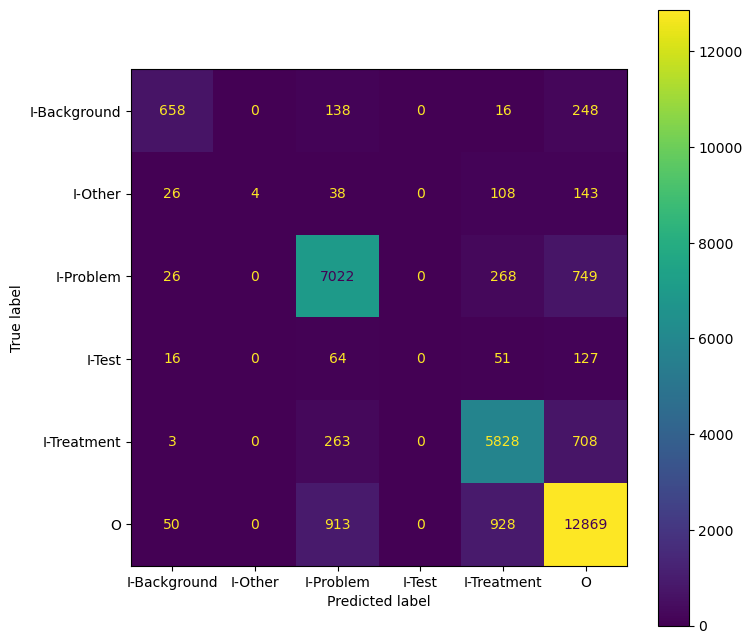

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.845   0.621     0.716   1060.000
I-Other           1.000   0.013     0.025    319.000
I-Problem         0.832   0.871     0.851   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.810   0.857     0.833   6802.000
O                 0.867   0.872     0.869  14760.000
accuracy          0.844   0.844     0.844      0.844
macro avg         0.726   0.539     0.549  31264.000
weighted avg      0.839   0.844     0.836  31264.000
macro_wo_O        0.697   0.472     0.485  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.861   0.655     0.744    985.00
I-Other           1.000   0.013     0.025    317.00
I-Problem         0.798   0.820     0.809   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.744   0.774     0.759   2875.00
O                 0.887   0.921     0.904  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

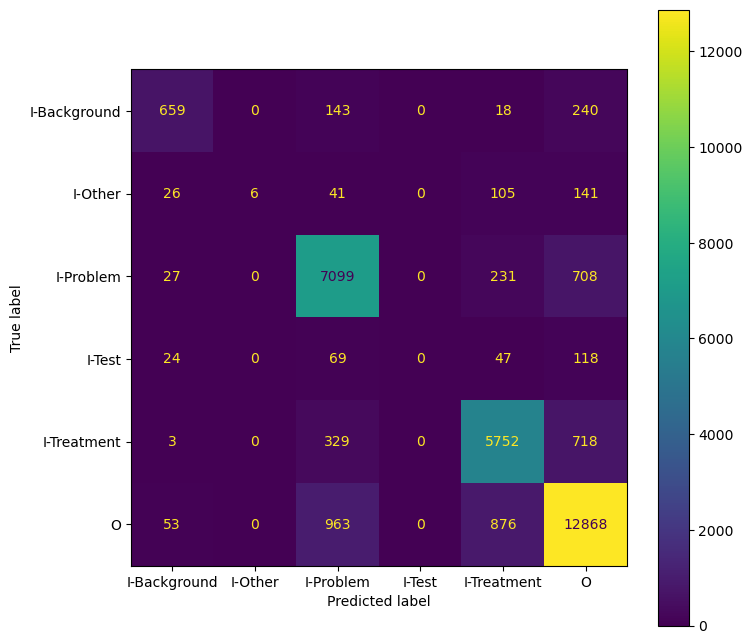

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.832   0.622     0.712   1060.000
I-Other           1.000   0.019     0.037    319.000
I-Problem         0.821   0.880     0.850   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.818   0.846     0.832   6802.000
O                 0.870   0.872     0.871  14760.000
accuracy          0.844   0.844     0.844      0.844
macro avg         0.724   0.540     0.550  31264.000
weighted avg      0.839   0.844     0.836  31264.000
macro_wo_O        0.694   0.473     0.486  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.849   0.656     0.740    985.00
I-Other           1.000   0.019     0.037    317.00
I-Problem         0.787   0.831     0.809   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.753   0.762     0.758   2875.00
O                 0.889   0.921     0.905  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

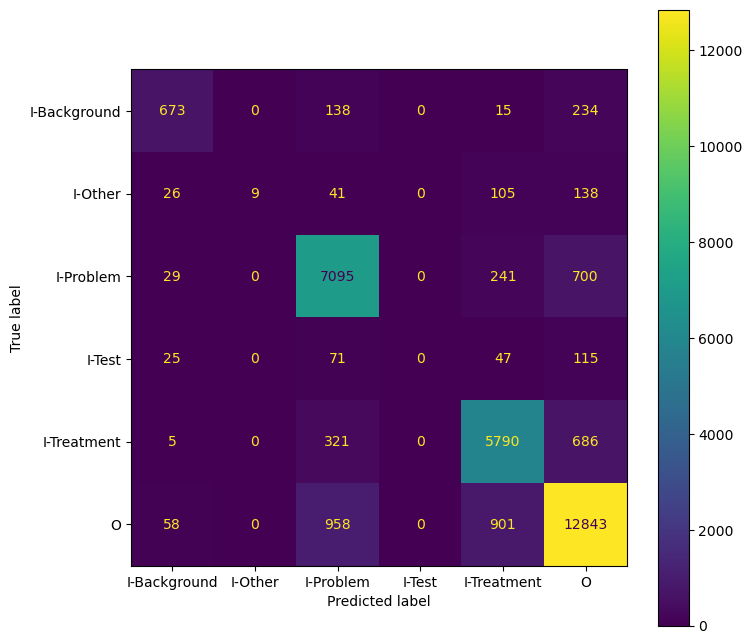

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.825   0.635     0.717   1060.000
I-Other           1.000   0.028     0.055    319.000
I-Problem         0.823   0.880     0.850   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.816   0.851     0.833   6802.000
O                 0.873   0.870     0.871  14760.000
accuracy          0.845   0.845     0.845      0.845
macro avg         0.723   0.544     0.555  31264.000
weighted avg      0.840   0.845     0.837  31264.000
macro_wo_O        0.693   0.479     0.491  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.844   0.669     0.746    985.000
I-Other           1.000   0.028     0.055    317.000
I-Problem         0.786   0.831     0.808   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.753   0.766     0.759   2875.000
O                 0.891   0.920     0.905  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

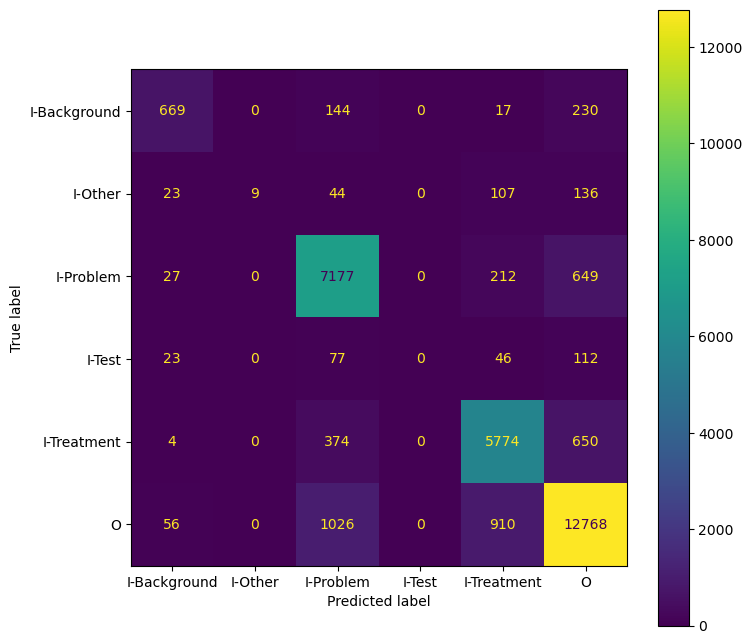

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.834   0.631     0.719   1060.000
I-Other           1.000   0.028     0.055    319.000
I-Problem         0.812   0.890     0.849   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.817   0.849     0.833   6802.000
O                 0.878   0.865     0.871  14760.000
accuracy          0.844   0.844     0.844      0.844
macro avg         0.723   0.544     0.554  31264.000
weighted avg      0.840   0.844     0.836  31264.000
macro_wo_O        0.693   0.480     0.491  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.851   0.666     0.747    985.00
I-Other           1.000   0.028     0.055    317.00
I-Problem         0.776   0.843     0.808   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.752   0.767     0.760   2875.00
O                 0.894   0.916     0.905  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

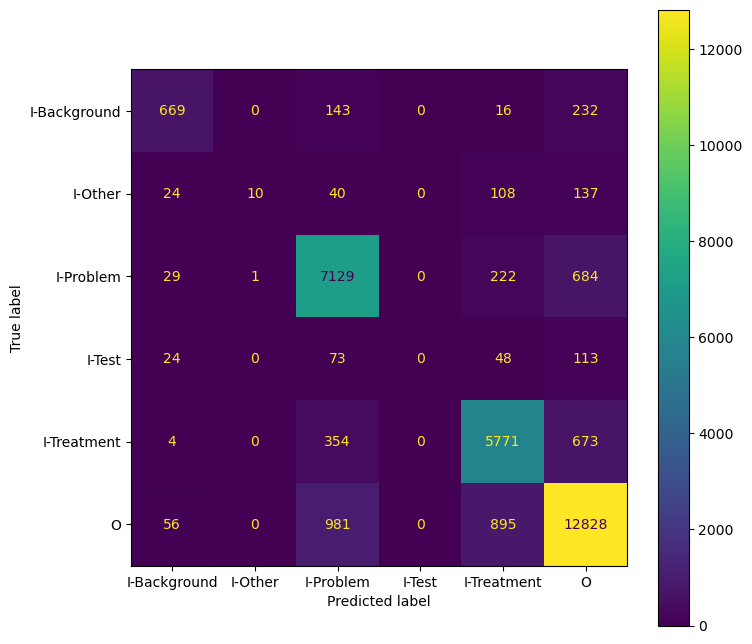

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.830   0.631     0.717   1060.000
I-Other           0.909   0.031     0.061    319.000
I-Problem         0.818   0.884     0.849   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.817   0.848     0.833   6802.000
O                 0.875   0.869     0.872  14760.000
accuracy          0.845   0.845     0.845      0.845
macro avg         0.708   0.544     0.555  31264.000
weighted avg      0.839   0.845     0.837  31264.000
macro_wo_O        0.675   0.479     0.492  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.848   0.666     0.746    985.000
I-Other           0.909   0.032     0.061    317.000
I-Problem         0.782   0.835     0.808   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.753   0.766     0.760   2875.000
O                 0.892   0.919     0.905  13463.000
accuracy  

TrainOutput(global_step=11600, training_loss=0.44692047645305766, metrics={'train_runtime': 3045.9461, 'train_samples_per_second': 30.459, 'train_steps_per_second': 3.808, 'total_flos': 2667930182685072.0, 'train_loss': 0.44692047645305766, 'epoch': 25.0})

In [25]:
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments
from transformers import BertModel, BertConfig
# from torchcrf import CRF

class CustomBertLSTMModel(BertModel):  # (832x50 and 768x13)
    def __init__(self, config):
        super().__init__(config)   
        self.lstm = nn.LSTM(input_size=config.hidden_size, hidden_size=50, num_layers=2, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(50*2, config.num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = super().forward(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        lstm_out, _ = self.lstm(sequence_output)
        logits = self.classifier(lstm_out)

        # Calculate the loss if labels are provided
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 6), labels.view(-1))
        else:
            loss = None

        return (loss, logits) if loss is not None else logits

config = BertConfig.from_pretrained('samrawal/bert-base-uncased_clinical-ner', num_labels=6)
lstm_model = CustomBertLSTMModel(config)


# Training arguments
lstm_training_args = TrainingArguments(
    output_dir='./lstm',
    num_train_epochs=25,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    overwrite_output_dir=True,
    learning_rate=1e-5,
    load_best_model_at_end=False,
)

# Trainer
lstm_trainer = Trainer(
    model=lstm_model,
    args=lstm_training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train the model
lstm_trainer.train()


In [ ]:
args = TrainingArguments(
    "bert-finetuned-ner",
    overwrite_output_dir=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False,
    learning_rate=1e-5,
    num_train_epochs=5,
    logging_strategy="epoch",
)

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.430600,0.330988,0.832899,0.786462,0.806233,0.884980
2,0.262200,0.312119,0.852939,0.791235,0.818679,0.892144
3,0.210900,0.316576,0.835605,0.818739,0.826060,0.895855
4,0.178500,0.327230,0.841760,0.815930,0.827696,0.897550
5,0.157400,0.333196,0.839770,0.820266,0.829005,0.897582


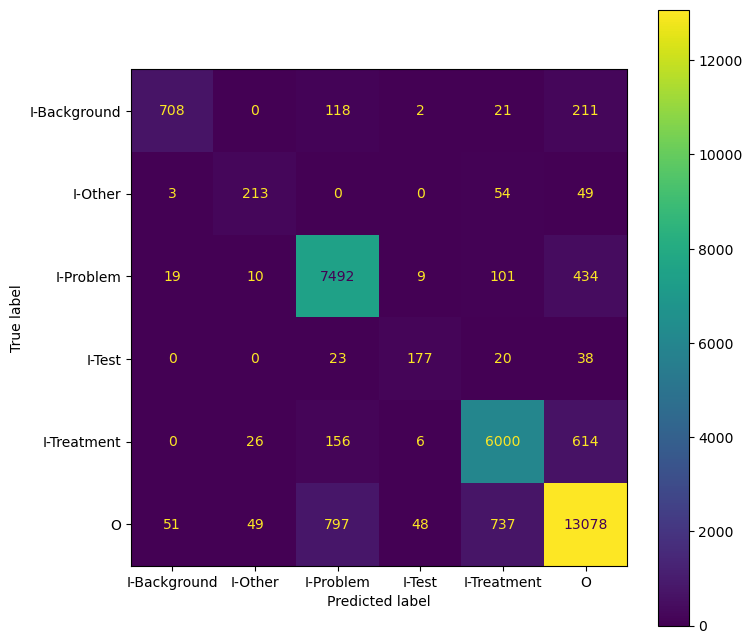

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.907   0.668     0.769   1060.000
I-Other           0.715   0.668     0.690    319.000
I-Problem         0.873   0.929     0.900   8065.000
I-Test            0.731   0.686     0.708    258.000
I-Treatment       0.865   0.882     0.874   6802.000
O                 0.907   0.886     0.896  14760.000
accuracy          0.885   0.885     0.885      0.885
macro avg         0.833   0.786     0.806  31264.000
weighted avg      0.886   0.885     0.884  31264.000
macro_wo_O        0.818   0.767     0.788  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.911   0.698     0.791    985.000
I-Other           0.714   0.669     0.691    317.000
I-Problem         0.845   0.895     0.869   3950.000
I-Test            0.861   0.663     0.749    205.000
I-Treatment       0.819   0.803     0.811   2875.000
O                 0.920   0.928     0.924  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


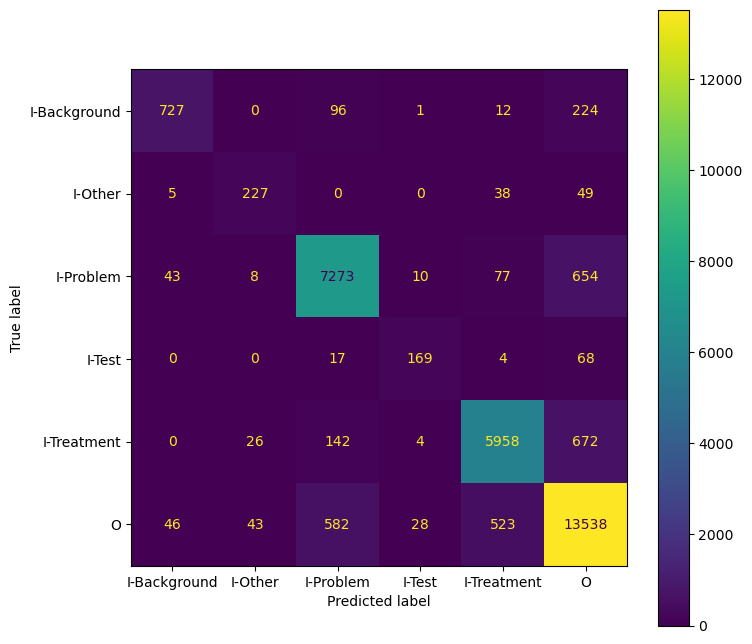

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.886   0.686     0.773   1060.000
I-Other           0.747   0.712     0.729    319.000
I-Problem         0.897   0.902     0.899   8065.000
I-Test            0.797   0.655     0.719    258.000
I-Treatment       0.901   0.876     0.888   6802.000
O                 0.890   0.917     0.904  14760.000
accuracy          0.892   0.892     0.892      0.892
macro avg         0.853   0.791     0.819  31264.000
weighted avg      0.892   0.892     0.891  31264.000
macro_wo_O        0.845   0.766     0.802  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.901   0.714     0.797    985.000
I-Other           0.747   0.716     0.731    317.000
I-Problem         0.878   0.859     0.869   3950.000
I-Test            0.859   0.624     0.723    205.000
I-Treatment       0.867   0.806     0.835   2875.000
O                 0.910   0.948     0.929  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


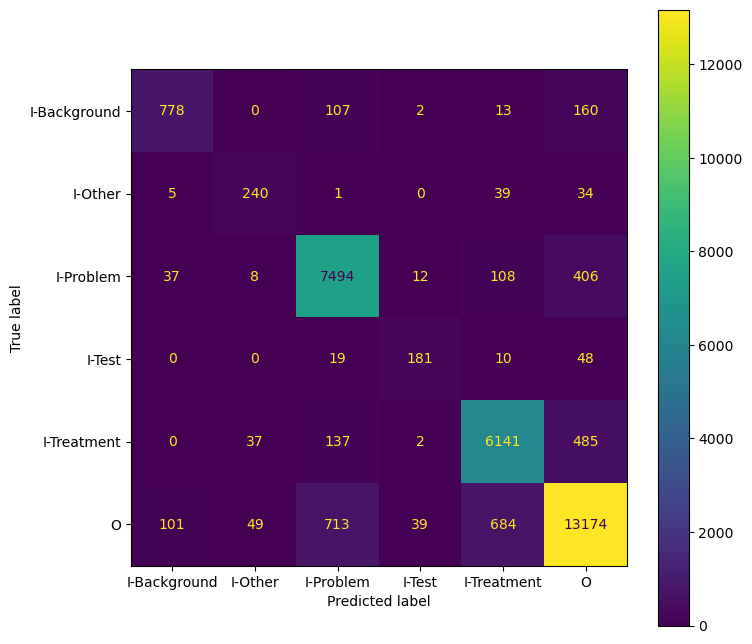

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.845   0.734     0.785   1060.000
I-Other           0.719   0.752     0.735    319.000
I-Problem         0.885   0.929     0.906   8065.000
I-Test            0.767   0.702     0.733    258.000
I-Treatment       0.878   0.903     0.890   6802.000
O                 0.921   0.893     0.906  14760.000
accuracy          0.896   0.896     0.896      0.896
macro avg         0.836   0.819     0.826  31264.000
weighted avg      0.896   0.896     0.896  31264.000
macro_wo_O        0.819   0.804     0.810  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score  support
I-Background      0.860   0.760     0.807    985.0
I-Other           0.721   0.757     0.738    317.0
I-Problem         0.859   0.900     0.879   3950.0
I-Test            0.838   0.683     0.753    205.0
I-Treatment       0.835   0.844     0.840   2875.0
O                 0.934   0.929     0.931  13463.0
accuracy          0.900 

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


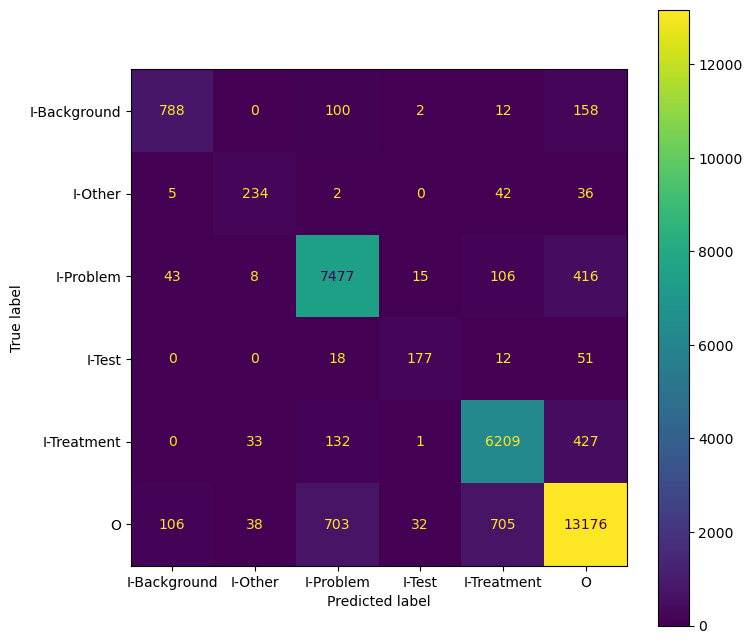

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.837   0.743     0.787   1060.000
I-Other           0.748   0.734     0.741    319.000
I-Problem         0.887   0.927     0.906   8065.000
I-Test            0.780   0.686     0.730    258.000
I-Treatment       0.876   0.913     0.894   6802.000
O                 0.924   0.893     0.908  14760.000
accuracy          0.898   0.898     0.898      0.898
macro avg         0.842   0.816     0.828  31264.000
weighted avg      0.898   0.898     0.897  31264.000
macro_wo_O        0.825   0.801     0.812  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.853   0.772     0.810    985.000
I-Other           0.750   0.738     0.744    317.000
I-Problem         0.863   0.899     0.881   3950.000
I-Test            0.821   0.673     0.740    205.000
I-Treatment       0.830   0.862     0.846   2875.000
O                 0.937   0.927     0.932  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


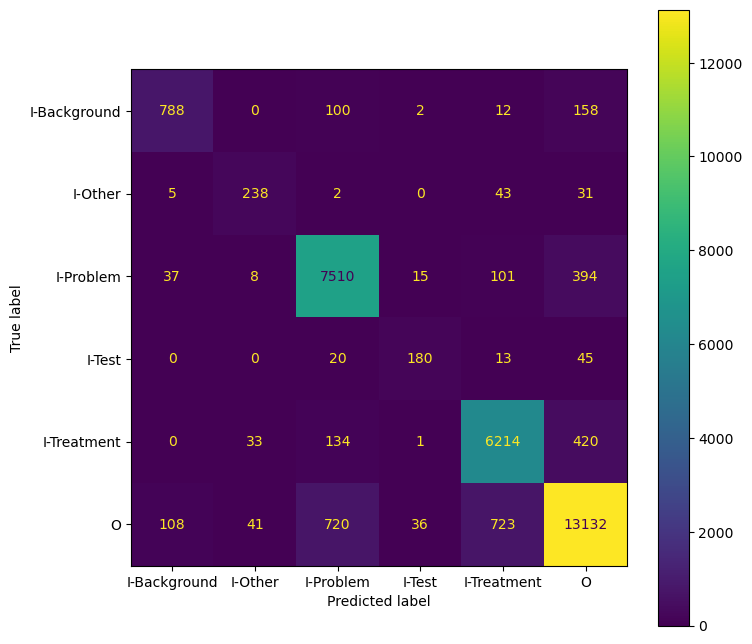

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.840   0.743     0.789   1060.000
I-Other           0.744   0.746     0.745    319.000
I-Problem         0.885   0.931     0.907   8065.000
I-Test            0.769   0.698     0.732    258.000
I-Treatment       0.874   0.914     0.894   6802.000
O                 0.926   0.890     0.908  14760.000
accuracy          0.898   0.898     0.898      0.898
macro avg         0.840   0.820     0.829  31264.000
weighted avg      0.898   0.898     0.897  31264.000
macro_wo_O        0.823   0.806     0.813  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.856   0.772     0.812    985.000
I-Other           0.746   0.751     0.748    317.000
I-Problem         0.861   0.906     0.883   3950.000
I-Test            0.810   0.688     0.744    205.000
I-Treatment       0.827   0.863     0.845   2875.000
O                 0.939   0.925     0.932  13463.000
accuracy  

TrainOutput(global_step=2320, training_loss=0.24790415928281587, metrics={'train_runtime': 549.1029, 'train_samples_per_second': 33.791, 'train_steps_per_second': 4.225, 'total_flos': 527858951087520.0, 'train_loss': 0.24790415928281587, 'epoch': 5.0})

In [ ]:


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

In [29]:
# evaluation_results = trainer.evaluate()

# validation_accuracy = evaluation_results['eval_accuracy']
# print(f"Validation Accuracy: {validation_accuracy}")

## Evaluate on mtsamples

In [37]:
from scipy.special import softmax



In [38]:
def transformm(example_batch):
    example_batch['sentence'] = ast.literal_eval(example_batch['sentence'])

    example_batch['tag'] = ast.literal_eval(example_batch['tag'])
 
    example_batch['tag'] = [label2id[label] for label in example_batch['tag']]
    return example_batch

In [39]:
from docx import Document
from docx.oxml.ns import qn
from docx.oxml import OxmlElement

def highlight_false_positives_to_docx(sentences, predictions, labels, file_path):
    doc = Document()
    if len(sentences) != len(predictions) != len(labels):
        raise ValueError("Number of sentences, predictions and labels must be the same")
    for sentence, pred_tags, true_tags in zip(sentences, predictions, labels):
        p = doc.add_paragraph()
        for word, pred_tag, true_tag in zip(sentence, pred_tags, true_tags):
            run = p.add_run(word + ' ')

            # print(word, pred_tag, true_tag)
            # If the prediction is wrong, make the word bold
            if pred_tag != true_tag:
                run.font.bold = True

            # Apply color coding based on the prediction
            color = None
            if pred_tag == "I-Problem":
                color = 'FF00FF'  # Pink
            elif pred_tag == "I-Treatment":
                color = '0000FF'  # blue
            elif pred_tag == "I-Other":
                color = 'FF0000'  # Red
            elif pred_tag == "I-Background":
                color = 'D3D3D3'  # Gray_25
            elif pred_tag == "I-Test":
                color = '00FF00' # green
                
            if color:
                rPr = run._element.get_or_add_rPr()
                shading_elm = OxmlElement('w:shd')
                shading_elm.set(qn('w:fill'), color)
                rPr.append(shading_elm)

    doc.save(file_path)


In [40]:
# Load the evaluation data
eval_dataset = load_dataset('csv', data_files='data/processed/mtsamples/final_eval.csv')
eval_dataset = eval_dataset.map(transformm)

In [41]:
# word ids of the tokenized mtsamples to find the original words
mtsamples_sentences = eval_dataset['train']['sentence']
mtsamples_word_ids = []
for sentence in mtsamples_sentences:
    mtsamples_word_ids.append(tokenizer(sentence, truncation=True, is_split_into_words=True).word_ids())

In [42]:
from seqeval.scheme import IOB2
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from seqeval.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

def compute_metricss(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    scores = softmax(logits, axis=-1)

     # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    y_true = [[0 if l == 0 else 1 for l in label if l != -100] for label in labels]
    y_scores = [[sum(s[1:]) for (s, l) in zip(score, label) if l != -100]
        for score, label in zip(scores, labels)]
    y_true = [item for sublist in y_true for item in sublist]
    y_scores = [item for sublist in y_scores for item in sublist]

    # `y_true` should be your binary true labels (0 for 'O', 1 for not 'O')
    # `y_scores` should be the binary scores you've computed as shown above

    # Calculate ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Plot ROC Curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    # plt.show()

   
   
    
    
    untokenized_true_labels, untokenized_predictions = untokenize_labels_predictions(mtsamples_word_ids, true_labels, true_predictions)
    print(true_labels[42])
    print(true_predictions[42])
    
    print(untokenized_true_labels[42])
    print(untokenized_predictions[42])
  
 
    
    flat_true = [label for seq in true_labels for label in seq]
    flat_pred = [label for seq in true_predictions for label in seq]
    report = classification_report(y_pred=flat_pred, y_true=flat_true, output_dict=True)
    report['macro_wo_O'] = {'precision': (report['I-Background']['precision'] + report['I-Other']['precision'] + report['I-Problem']['precision'] + report['I-Test']['precision'] + report['I-Treatment']['precision']) / 5,
    'recall': (report['I-Background']['recall'] + report['I-Other']['recall'] + report['I-Problem']['recall'] + report['I-Test']['recall'] + report['I-Treatment']['recall']) / 5,
    'f1-score': (report['I-Background']['f1-score'] + report['I-Other']['f1-score'] + report['I-Problem']['f1-score'] + report['I-Test']['f1-score'] + report['I-Treatment']['f1-score']) / 5,
    'support': (report['I-Background']['support'] + report['I-Other']['support'] + report['I-Problem']['support'] + report['I-Test']['support'] + report['I-Treatment']['support'])}
    
    report_df = pd.DataFrame(report).round(3).T


    unflat_true = [label for seq in untokenized_true_labels for label in seq]
    unflat_pred = [label for seq in untokenized_predictions for label in seq]
    unreport = classification_report(y_pred=unflat_pred, y_true=unflat_true, output_dict=True)
    unreport['macro_wo_O'] = {'precision': (unreport['I-Background']['precision'] + unreport['I-Other']['precision'] + unreport['I-Problem']['precision'] + unreport['I-Test']['precision'] + unreport['I-Treatment']['precision']) / 5,
    'recall': (unreport['I-Background']['recall'] + unreport['I-Other']['recall'] + unreport['I-Problem']['recall'] + unreport['I-Test']['recall'] + unreport['I-Treatment']['recall']) / 5,
    'f1-score': (unreport['I-Background']['f1-score'] + unreport['I-Other']['f1-score'] + unreport['I-Problem']['f1-score'] + unreport['I-Test']['f1-score'] + unreport['I-Treatment']['f1-score']) / 5,
    'support': (unreport['I-Background']['support'] + unreport['I-Other']['support'] + unreport['I-Problem']['support'] + unreport['I-Test']['support'] + unreport['I-Treatment']['support'])}
    
    un_report_df = pd.DataFrame(unreport).round(3).T

    binary_predictions = ['0' if label == 'O' else '1' for label in unflat_pred]
    binary_labels = ['0' if label == 'O' else '1' for label in unflat_true]

    # Generate a classification report
    binary_classification_report = classification_report(y_true=binary_labels, y_pred=binary_predictions, target_names=['O', 'I'], digits=3)
    

   

    cm = confusion_matrix(y_pred=flat_pred, y_true=flat_true)
    disp = ConfusionMatrixDisplay(cm, display_labels=np.array(['I-Background','I-Other', 'I-Problem', 'I-Test', 'I-Treatment', 'O']))
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax)

    # Save the figure to an image file
    plt.savefig('analysis/graphs/mtsamples/confusion_matrix.png')
    plt.show()

    report_df = pd.DataFrame(report).round(3).T
    print("BINARY CLASSIFICATION REPORT")
    print(binary_classification_report)
    print("TOKENIZED REPORT")
    print(report_df)
    print("UNTOKENIZED REPORT")
    print(un_report_df)
   
    
    # highlight fp
    highlight_false_positives_to_docx(eval_df['sentence'], untokenized_predictions, untokenized_true_labels,  'analysis/reports/highlighted_false_positives.docx')

    # Calculate metrics using seqeval
    return {
        "f1": f1_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        # Add the confusion matrix 
        
    }



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'input_ids': [101, 5776, 1024, 1044, 3449, 4135, 3460, 999, 2026, 2171, 2003, 7673, 1012, 5907, 2003, 2931, 1012, 2287, 2003, 2423, 1012, 2026, 2364, 3277, 2003, 1024, 6659, 4308, 3255, 1010, 20868, 17728, 8553, 1010, 14978, 1012, 2019, 23238, 2278, 1998, 2635, 10768, 18933, 2271, 26754, 1012, 2026, 2783, 20992, 2024, 1024, 3904, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -100]}


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


['O', 'O', 'O', 'I-Problem', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-Problem', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'I-Problem', 'O', 'O', 'O', 'O', 'I-Other', 'I-Other', 'I-Other', 'O', 'O', 'O', 'O', 'I-Problem', 'I-Problem', 'I-Problem', 'O', 'I-Other', 'I-Other', 'O', 'O', 'O']
['O', 'O', 'O', 'I-Problem', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-Problem', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'I-Problem', 'O', 'O', 'O', 'O', 'I-Other', 'I-Other', 'I-Other', 'O', 'O', 'O', 'O', 'I-Problem', 'I-Problem', 'I-Problem', 'O', 'I-Other', 'I-Other', 'O', 'O', 'O']


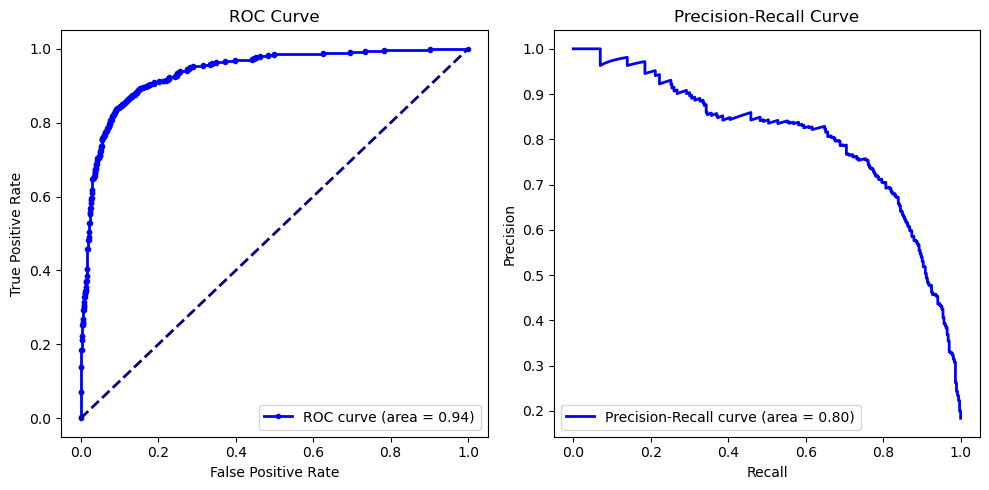

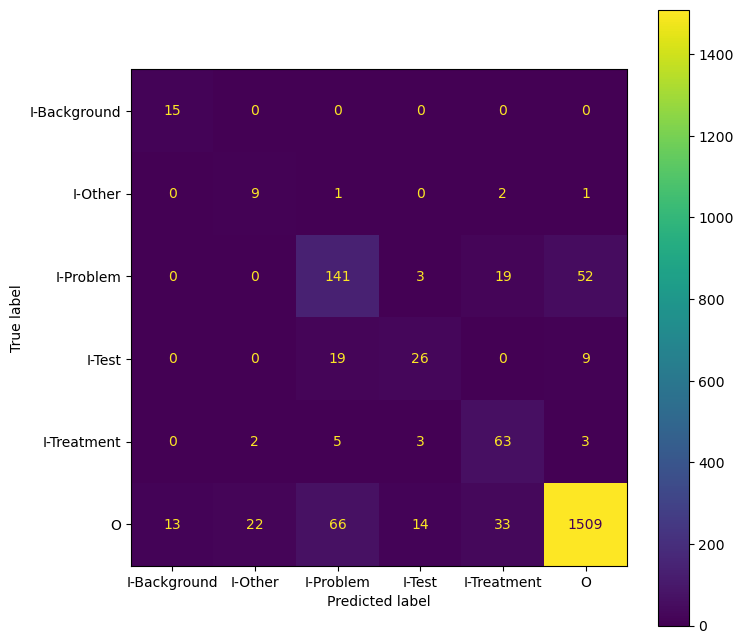

BINARY CLASSIFICATION REPORT
              precision    recall  f1-score   support

           O      0.964     0.917     0.940      1607
           I      0.624     0.801     0.701       277

    accuracy                          0.900      1884
   macro avg      0.794     0.859     0.821      1884
weighted avg      0.914     0.900     0.905      1884

TOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.536   1.000     0.698    15.000
I-Other           0.273   0.692     0.391    13.000
I-Problem         0.608   0.656     0.631   215.000
I-Test            0.565   0.481     0.520    54.000
I-Treatment       0.538   0.829     0.653    76.000
O                 0.959   0.911     0.934  1657.000
accuracy          0.868   0.868     0.868     0.868
macro avg         0.580   0.762     0.638  2030.000
weighted avg      0.888   0.868     0.875  2030.000
macro_wo_O        0.504   0.732     0.579   373.000
UNTOKENIZED REPORT
              precision  recall  f1-

In [43]:
# Load the tokenizer
checkpoint_path = 'bert-finetuned-ner/checkpoint-2320'
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

# Load the model
model = AutoModelForTokenClassification.from_pretrained(checkpoint_path)


# Prepare the evaluation dataset
eval_dataset = eval_dataset.map(tokenize_and_align_labels, batched=True, remove_columns=eval_dataset['train'].column_names)



# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    do_predict=True,
    per_device_eval_batch_size=4
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metricss,
)

# Evaluate the model
print(eval_dataset['train'][0])
results = trainer.evaluate(eval_dataset['train'])

print(results)


In [144]:
eval_dataset['train'][43]

{'input_ids': [101,
  5776,
  5281,
  1037,
  2309,
  2792,
  1997,
  2010,
  4432,
  16922,
  1012,
  2076,
  1996,
  2792,
  1010,
  2002,
  2371,
  19029,
  3064,
  1998,
  4298,
  2422,
  4974,
  2098,
  1012,
  2010,
  2564,
  2001,
  2556,
  1998,
  3264,
  2008,
  2002,
  2246,
  5186,
  5122,
  1012,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [-100,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  0,
  0,
  3,
  3,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  3,
  0,
  -100]}

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.339800,1.181378,0.197947,0.272324,0.226435,0.605713
2,1.058400,0.990710,0.532422,0.348553,0.375845,0.675154
3,0.876100,0.838394,0.557929,0.446716,0.474234,0.780642
4,0.760200,0.756434,0.561631,0.479922,0.500287,0.805911
5,0.681900,0.707588,0.567452,0.480763,0.505064,0.809461
6,0.627900,0.680360,0.565721,0.493492,0.512536,0.814259
7,0.588400,0.646212,0.567279,0.498393,0.518990,0.820177
8,0.559500,0.630567,0.567509,0.502759,0.521337,0.823439
9,0.539700,0.620765,0.570573,0.499448,0.520039,0.823887
10,0.528000,0.615156,0.569660,0.502995,0.522330,0.825262


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/.cond

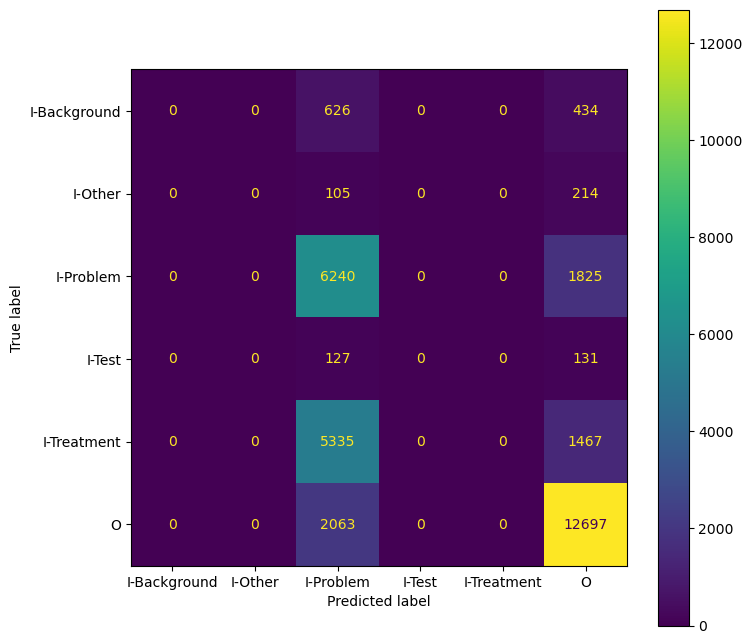

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.000   0.000     0.000   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.430   0.774     0.553   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.000   0.000     0.000   6802.000
O                 0.757   0.860     0.805  14760.000
accuracy          0.606   0.606     0.606      0.606
macro avg         0.198   0.272     0.226  31264.000
weighted avg      0.469   0.606     0.523  31264.000
macro_wo_O        0.086   0.155     0.111  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.000   0.000     0.000    985.00
I-Other           0.000   0.000     0.000    317.00
I-Problem         0.407   0.634     0.496   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.000   0.000     0.000   2875.00
O                 0.788   0.916     0.847  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

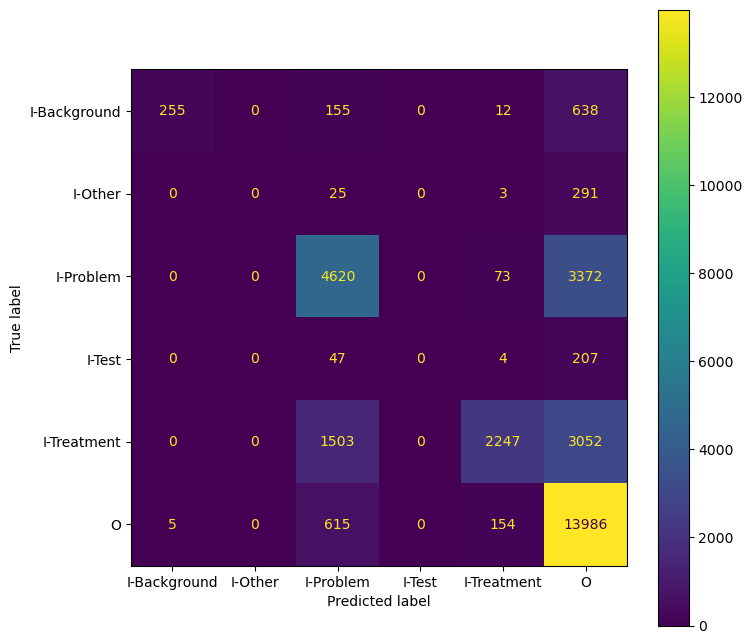

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.981   0.241     0.386   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.663   0.573     0.615   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.901   0.330     0.483   6802.000
O                 0.649   0.948     0.770  14760.000
accuracy          0.675   0.675     0.675      0.675
macro avg         0.532   0.349     0.376  31264.000
weighted avg      0.707   0.675     0.641  31264.000
macro_wo_O        0.509   0.229     0.297  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.981   0.258     0.408    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.663   0.435     0.526   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.894   0.203     0.331   2875.000
O                 0.719   0.977     0.829  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

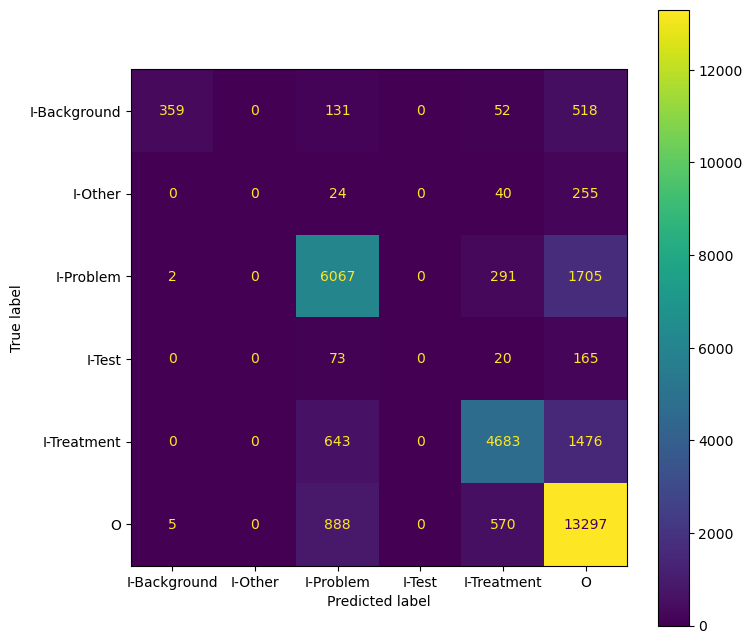

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.981   0.339     0.504   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.775   0.752     0.764   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.828   0.688     0.752   6802.000
O                 0.763   0.901     0.827  14760.000
accuracy          0.781   0.781     0.781      0.781
macro avg         0.558   0.447     0.474  31264.000
weighted avg      0.774   0.781     0.768  31264.000
macro_wo_O        0.517   0.356     0.404  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.981   0.362     0.529    985.00
I-Other           0.000   0.000     0.000    317.00
I-Problem         0.756   0.629     0.687   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.783   0.555     0.650   2875.00
O                 0.794   0.950     0.865  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

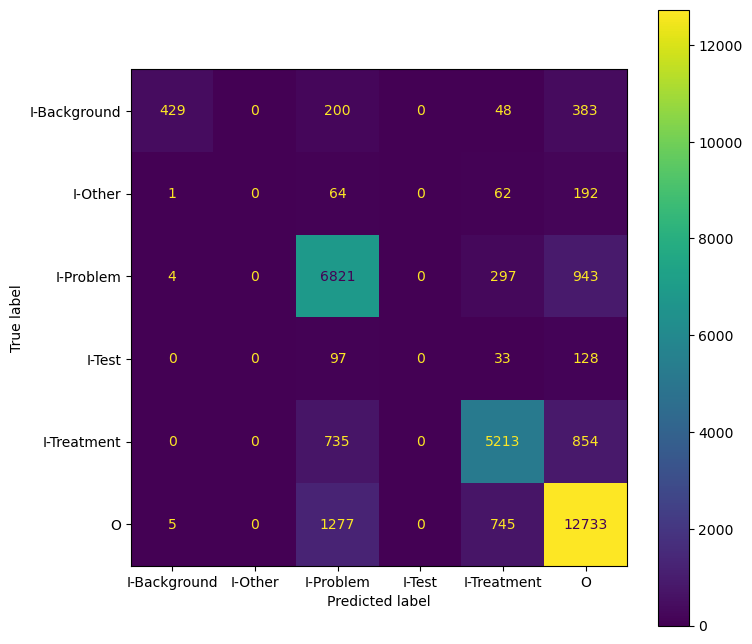

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.977   0.405     0.572   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.742   0.846     0.790   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.815   0.766     0.790   6802.000
O                 0.836   0.863     0.849  14760.000
accuracy          0.806   0.806     0.806      0.806
macro avg         0.562   0.480     0.500  31264.000
weighted avg      0.796   0.806     0.796  31264.000
macro_wo_O        0.507   0.403     0.431  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.979   0.432     0.600    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.704   0.766     0.734   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.757   0.660     0.705   2875.000
O                 0.851   0.920     0.884  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

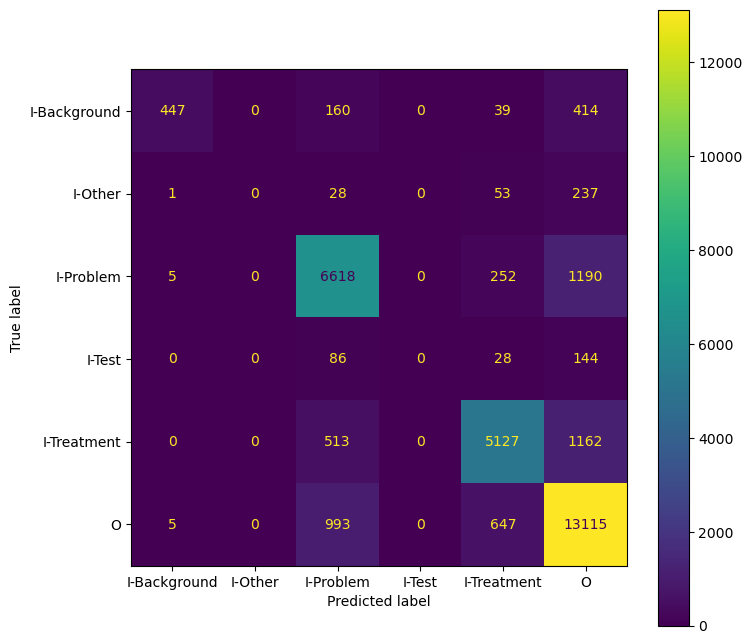

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.976   0.422     0.589   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.788   0.821     0.804   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.834   0.754     0.792   6802.000
O                 0.806   0.889     0.846  14760.000
accuracy          0.809   0.809     0.809      0.809
macro avg         0.567   0.481     0.505  31264.000
weighted avg      0.799   0.809     0.799  31264.000
macro_wo_O        0.520   0.399     0.437  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.978   0.451     0.617    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.762   0.729     0.745   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.784   0.634     0.701   2875.000
O                 0.830   0.939     0.881  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

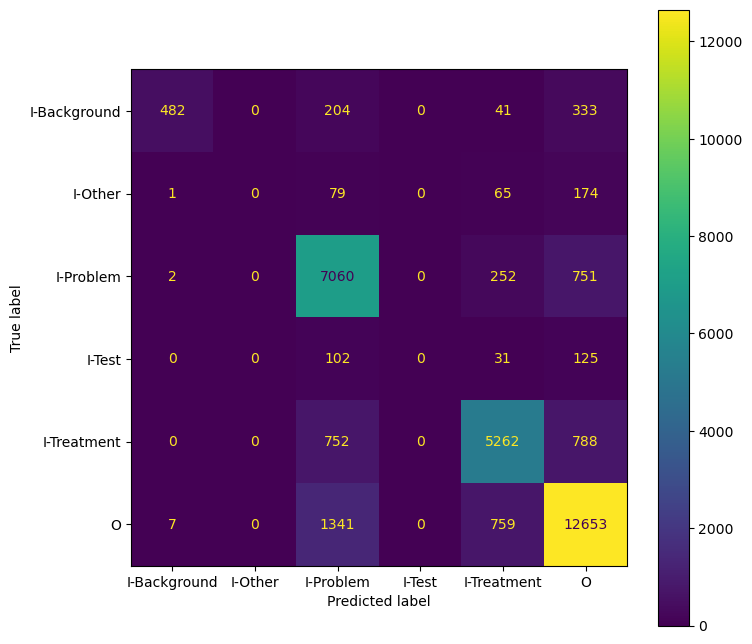

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.980   0.455     0.621   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.740   0.875     0.802   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.821   0.774     0.797   6802.000
O                 0.854   0.857     0.855  14760.000
accuracy          0.814   0.814     0.814      0.814
macro avg         0.566   0.493     0.513  31264.000
weighted avg      0.806   0.814     0.805  31264.000
macro_wo_O        0.508   0.421     0.444  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.980   0.486     0.650    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.702   0.811     0.753   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.765   0.670     0.714   2875.000
O                 0.867   0.916     0.891  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

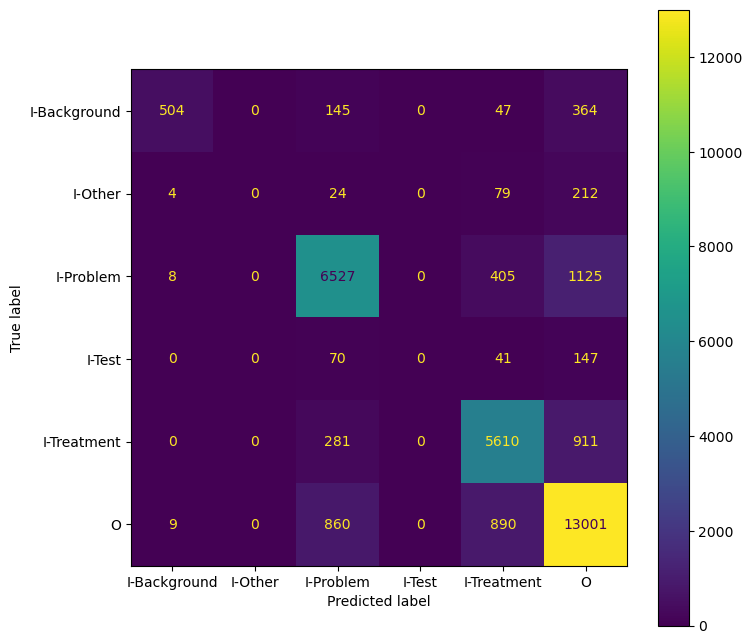

TOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.960   0.475     0.636   1060.00
I-Other           0.000   0.000     0.000    319.00
I-Problem         0.825   0.809     0.817   8065.00
I-Test            0.000   0.000     0.000    258.00
I-Treatment       0.793   0.825     0.809   6802.00
O                 0.825   0.881     0.852  14760.00
accuracy          0.820   0.820     0.820      0.82
macro avg         0.567   0.498     0.519  31264.00
weighted avg      0.808   0.820     0.811  31264.00
macro_wo_O        0.516   0.422     0.452  16504.00
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.963   0.509     0.666    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.795   0.729     0.761   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.732   0.719     0.726   2875.000
O                 0.847   0.933     0.888  13463.000
accuracy          0.8

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

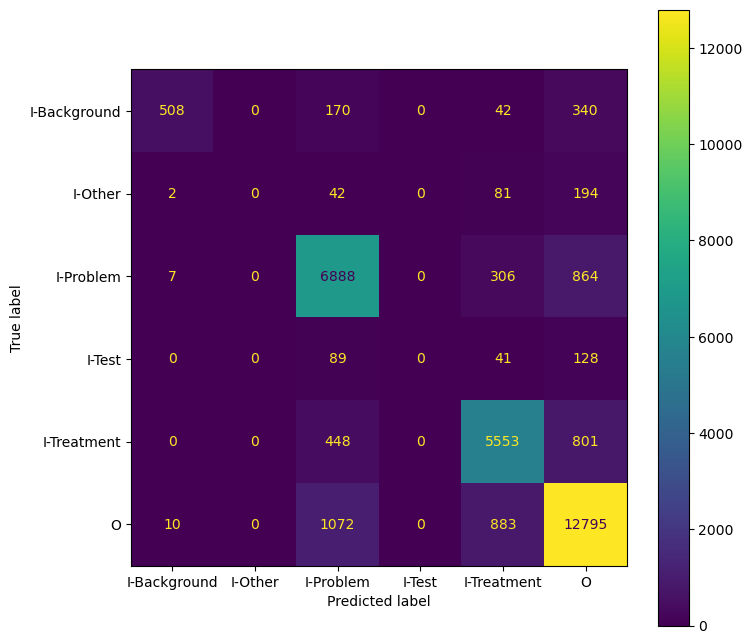

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.964   0.479     0.640   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.791   0.854     0.821   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.804   0.816     0.810   6802.000
O                 0.846   0.867     0.856  14760.000
accuracy          0.823   0.823     0.823      0.823
macro avg         0.568   0.503     0.521  31264.000
weighted avg      0.811   0.823     0.814  31264.000
macro_wo_O        0.512   0.430     0.454  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.967   0.513     0.670    985.00
I-Other           0.000   0.000     0.000    317.00
I-Problem         0.758   0.785     0.772   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.743   0.717     0.730   2875.00
O                 0.862   0.923     0.891  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

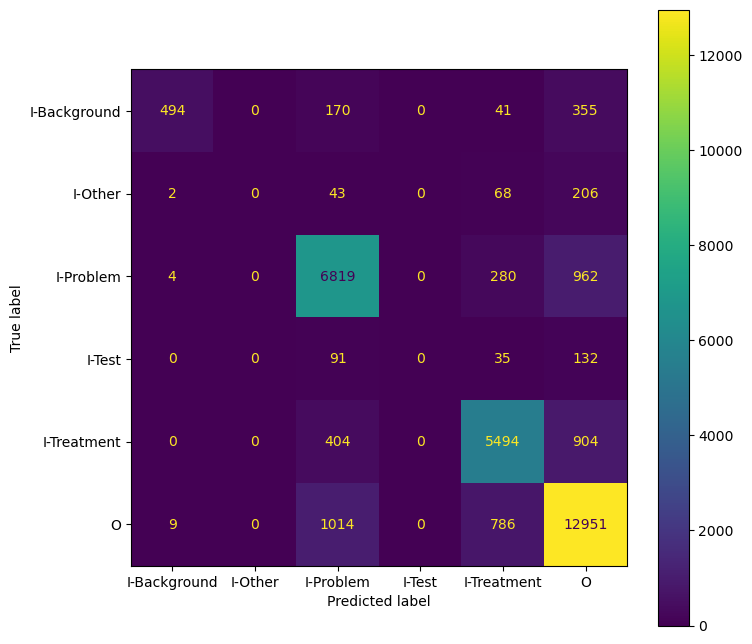

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.971   0.466     0.630   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.798   0.846     0.821   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.820   0.808     0.814   6802.000
O                 0.835   0.877     0.856  14760.000
accuracy          0.824   0.824     0.824      0.824
macro avg         0.571   0.499     0.520  31264.000
weighted avg      0.811   0.824     0.814  31264.000
macro_wo_O        0.518   0.424     0.453  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.972   0.498     0.659    985.00
I-Other           0.000   0.000     0.000    317.00
I-Problem         0.766   0.772     0.769   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.762   0.702     0.731   2875.00
O                 0.854   0.930     0.890  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

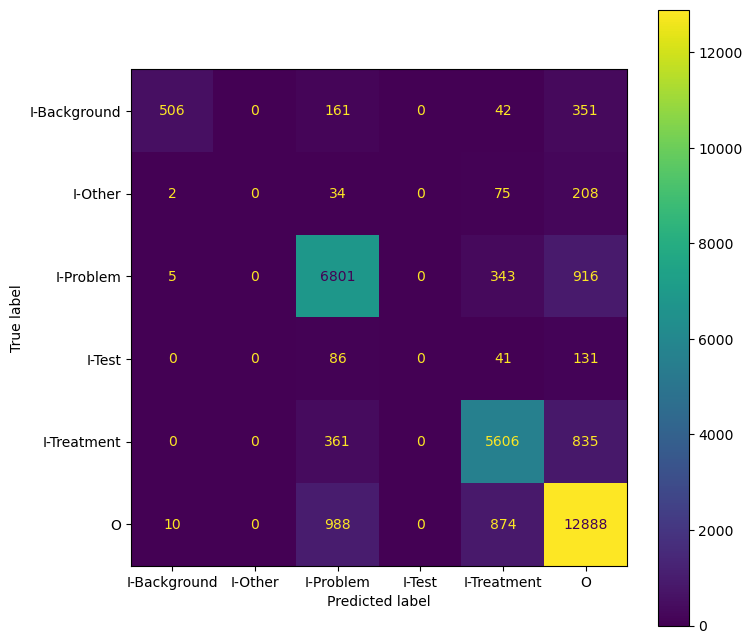

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.967   0.477     0.639   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.807   0.843     0.825   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.803   0.824     0.813   6802.000
O                 0.841   0.873     0.857  14760.000
accuracy          0.825   0.825     0.825      0.825
macro avg         0.570   0.503     0.522  31264.000
weighted avg      0.813   0.825     0.816  31264.000
macro_wo_O        0.515   0.429     0.455  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.971   0.511     0.669    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.773   0.774     0.773   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.745   0.721     0.733   2875.000
O                 0.858   0.927     0.891  13463.000
accuracy  

TrainOutput(global_step=4640, training_loss=0.755986345225367, metrics={'train_runtime': 1218.4138, 'train_samples_per_second': 30.458, 'train_steps_per_second': 3.808, 'total_flos': 1068155154801576.0, 'train_loss': 0.755986345225367, 'epoch': 10.0})

In [24]:
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments
from transformers import BertModel, BertConfig
# from torchcrf import CRF

class CustomBertLSTMModel(BertModel):  # (832x50 and 768x13)
    def __init__(self, config):
        super().__init__(config)   
        self.lstm = nn.LSTM(input_size=config.hidden_size, hidden_size=50, num_layers=2, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(50*2, config.num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = super().forward(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        lstm_out, _ = self.lstm(sequence_output)
        logits = self.classifier(lstm_out)

        # Calculate the loss if labels are provided
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 6), labels.view(-1))
        else:
            loss = None

        return (loss, logits) if loss is not None else logits

config = BertConfig.from_pretrained('samrawal/bert-base-uncased_clinical-ner', num_labels=6)
lstm_model = CustomBertLSTMModel(config)


# Training arguments
lstm_training_args = TrainingArguments(
    output_dir='./lstm',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    overwrite_output_dir=True,
    learning_rate=1e-5,
    load_best_model_at_end=False,
)

# Trainer
lstm_trainer = Trainer(
    model=lstm_model,
    args=lstm_training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train the model
lstm_trainer.train()


# Evaluate LSTM

In [157]:
# Load the tokenizer
checkpoint_path = 'lstm/checkpoint-464'
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

# Load the model
model = AutoModelForTokenClassification.from_pretrained(checkpoint_path)

# do not repeat done for bert clinical evaluation
# # Prepare the evaluation dataset
# eval_dataset = eval_dataset.map(tokenize_and_align_labels, batched=True, remove_columns=eval_dataset['train'].column_names)



# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    do_predict=True,
    per_device_eval_batch_size=4
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metricss,
)

# Evaluate the model
print(eval_dataset['train'][0])
results = trainer.evaluate(eval_dataset['train'])

print(results)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


ValueError: The state dictionary of the model you are trying to load is corrupted. Are you sure it was properly saved?